In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

In [69]:
lockdown_pd = pd.read_csv('lockdown_pd.csv')
summer_pd = pd.read_csv('summer_pd.csv')
deviance = pd.read_csv('deviance_df.csv')
static_data = pd.read_csv('processed_static_data.csv')
mobility = pd.read_csv('mobility_features.csv')
all_data = pd.read_csv('all_data_with_intervals.csv')

In [3]:
features_to_resum = ['Count_internal','Count_incoming']

for f in features_to_resum:
    for p in ['','_p_pop']:
        var_work = f + '_workday' + p
        var_off = f + '_day_off' + p
        mobility[f + p] = mobility[var_work] + mobility[var_off]

In [4]:
mobility['yyww'] = mobility.year * 100 + mobility.week_no - 200000
bad_weeks = [1940,2001,2040]
#weeks where we did not have 7 days of data, 
#these were at the edges of timeframes we have,
#with 1927 as beginning of 2019 data luckily being a monday.
mobility = mobility[~mobility.yyww.isin(bad_weeks)].copy()

In [30]:
full_baseline = mobility[mobility.yyww < 2006].copy()
baseline_2019 = mobility[mobility.yyww < 2000].copy()
til_lockdown = mobility[mobility.yyww < 2011].copy()

In [34]:
baselines = []
for df in [full_baseline,baseline_2019,til_lockdown]:
    bl = df.groupby('districtId')[['Count_incoming','Count_internal']].mean().reset_index()
    baselines.append(bl)
    
baseline_df = baselines[0]
for i in range(1, len(baselines)):
    
    baseline_df = pd.merge(baseline_df, baselines[i], on = 'districtId',suffixes = ('',str(i)))

In [35]:
baseline_df.corr()

,districtId,Count_incoming,Count_internal,Count_incoming1,Count_internal1,Count_incoming2,Count_internal2
districtId,1.000000,-0.138015,-0.092724,-0.133241,-0.090972,-0.141091,-0.094678
Count_incoming,-0.138015,1.000000,0.792243,0.999824,0.792031,0.999932,0.792361
Count_internal,-0.092724,0.792243,1.000000,0.795857,0.999945,0.790446,0.999971
Count_incoming1,-0.133241,0.999824,0.795857,1.000000,0.795749,0.999585,0.795929
Count_internal1,-0.090972,0.792031,0.999945,0.795749,1.000000,0.790200,0.999857
Count_incoming2,-0.141091,0.999932,0.790446,0.999585,0.790200,1.000000,0.790596
Count_internal2,-0.094678,0.792361,0.999971,0.795929,0.999857,0.790596,1.000000


Baseline only 2019 data or including January or up until the lockdown does not make any difference whatsoever!

In [46]:
vars_to_include = baseline_2019.filter(like='Count').columns

In [47]:
base_mean = baseline_2019.groupby('districtId')[vars_to_include].mean().reset_index()

In [51]:
base_std = baseline_2019.groupby('districtId')[vars_to_include].std().reset_index()

In [54]:
baseline = pd.merge(base_mean, base_std, on = 'districtId', suffixes = ('_mean','_std'))

In [55]:
baseline

,districtId,Count_internal_workday_mean,Count_internal_day_off_mean,Count_incoming_workday_mean,Count_incoming_day_off_mean,Count_internal_workday_p_pop_mean,Count_internal_day_off_p_pop_mean,Count_incoming_workday_p_pop_mean,Count_incoming_day_off_p_pop_mean,Count_internal_mean,...,Count_incoming_workday_std,Count_incoming_day_off_std,Count_internal_workday_p_pop_std,Count_internal_day_off_p_pop_std,Count_incoming_workday_p_pop_std,Count_incoming_day_off_p_pop_std,Count_internal_std,Count_internal_p_pop_std,Count_incoming_std,Count_incoming_p_pop_std
0,1001,7.109511e+05,198640.307692,306435.692308,92397.923077,7.885088,2.203100,3.398648,1.024776,9.095914e+05,...,17254.631795,5483.728179,0.852606,0.182158,0.191369,0.060819,89851.934319,0.996539,18091.749116,0.200654
1,1002,2.019699e+06,550146.538462,825472.461538,250202.076923,8.183745,2.229173,3.344783,1.013809,2.569846e+06,...,46375.399076,10208.802709,0.549443,0.091226,0.187911,0.041366,151521.810488,0.613961,52490.477653,0.212689
2,1003,1.614778e+06,473663.461538,696595.153846,218614.230769,7.457527,2.187519,3.217084,1.009626,2.088442e+06,...,20868.716028,8979.676026,0.374956,0.069336,0.096378,0.041471,82117.493341,0.379243,22346.310947,0.103202
3,1004,6.270900e+05,182150.923077,318462.307692,94774.076923,7.819467,2.271322,3.971050,1.181781,8.092409e+05,...,9330.541351,6557.778644,0.554663,0.144243,0.116347,0.081772,53577.475795,0.668082,12992.835298,0.162014
4,1051,1.105403e+06,346536.153846,246355.538462,92749.615385,8.299256,2.601760,1.849613,0.696355,1.451939e+06,...,11061.674802,9650.299845,0.347569,0.184690,0.083050,0.072454,58586.817982,0.439864,18823.928809,0.141328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,16073,1.018312e+06,330195.000000,215447.846154,76736.846154,9.867461,3.199595,2.087693,0.743581,1.348507e+06,...,18915.494032,12710.903999,1.017871,0.609899,0.183291,0.123169,133802.654947,1.296550,18610.334984,0.180334
397,16074,3.673968e+05,116490.769231,400649.846154,117155.076923,4.429136,1.404349,4.830016,1.412358,4.838876e+05,...,31754.271069,20211.097251,0.413415,0.217835,0.382812,0.243654,36653.137466,0.441870,31023.076273,0.373997
398,16075,4.682809e+05,158397.153846,267145.153846,86619.153846,5.830772,1.972273,3.326342,1.078533,6.266781e+05,...,19682.380758,13117.134417,0.436898,0.330659,0.245074,0.163327,38134.876748,0.474834,13774.215074,0.171509
399,16076,6.136325e+05,193623.538462,400324.923077,123129.000000,6.300257,1.987962,4.110197,1.264184,8.072560e+05,...,28407.788109,22952.592802,0.531491,0.280366,0.291667,0.235658,45169.786561,0.463765,22510.074443,0.231114


In [71]:
all_data = all_data.merge(baseline, on='districtId').merge(deviance, on='districtId')

In [72]:
for c in vars_to_include:
    all_data[c+'_z'] = (all_data[c] - all_data[c+'_mean']) / all_data[c+'_std']

In [78]:
lockdown = all_data[all_data.active_lockdown].copy()

In [85]:
np.corrcoef(lockdown.Count_internal_z, lockdown.lockdown_z)

array([[ 1.        , -0.06879178],
       [-0.06879178,  1.        ]])

In [92]:
def plot_district_mobi(districtId,count_type='internal'):
    dist_data = all_data[all_data.districtId == districtId].copy()
    fig = go.Figure()
    count_var = 'Count_'+count_type+'_z'
    fig.add_trace(go.Scatter(x=dist_data.week_no,
                            y=dist_data[count_var]))
    fig.show()

In [111]:
all_data.groupby('districtId')[['Count_internal_z','Count_incoming_z']].min().sort_values('Count_incoming_z')

,Count_internal_z,Count_incoming_z
districtId,,
2000,-11.525351,-40.944922
6431,-6.505490,-35.454795
11000,-10.023399,-27.747560
6433,-6.863617,-27.347379
6631,-6.928836,-27.327208
...,...,...
13071,-6.314597,-4.490001
1061,-2.980643,-4.218426
12062,-4.231135,-3.488343


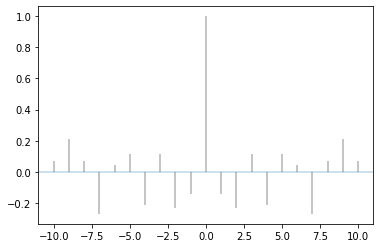

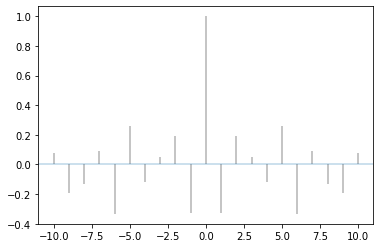

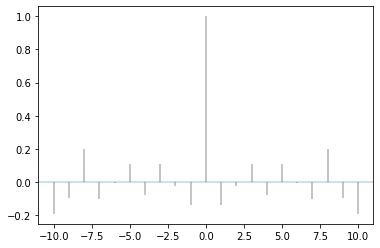

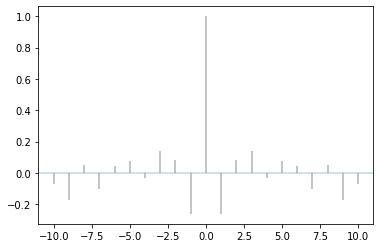

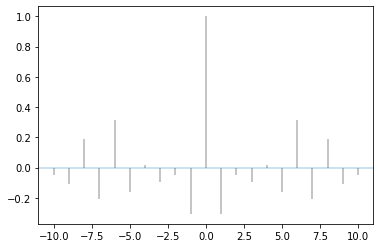

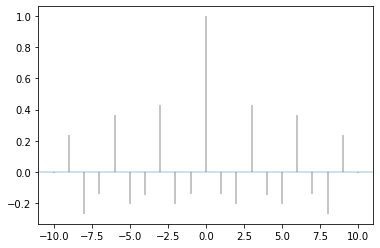

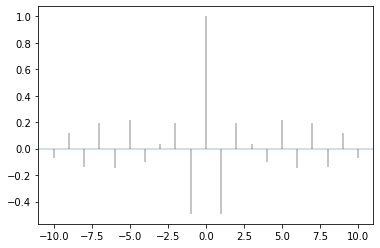

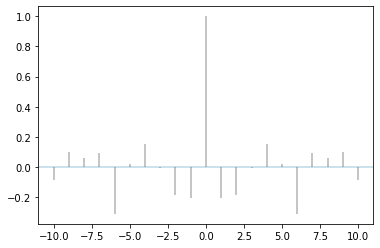

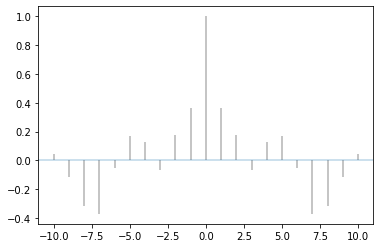

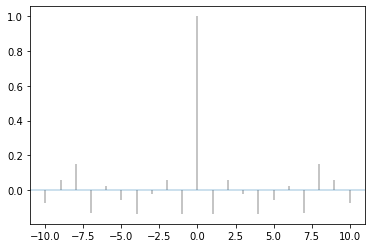

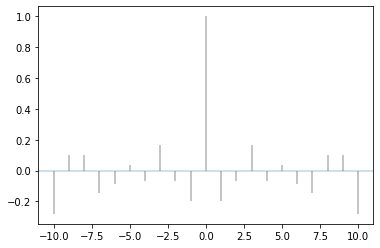

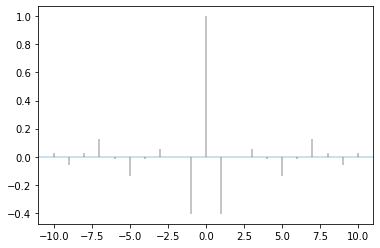

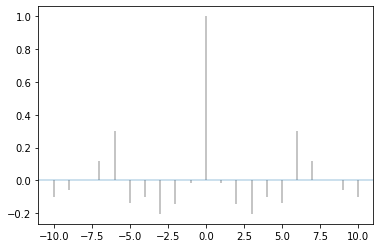

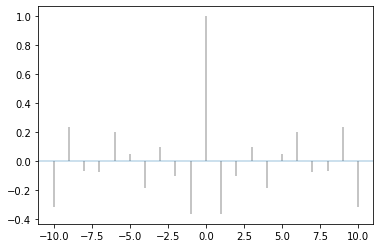

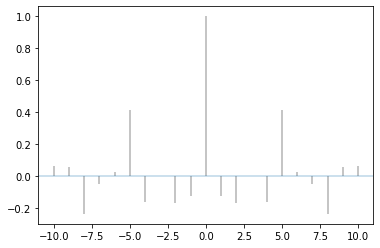

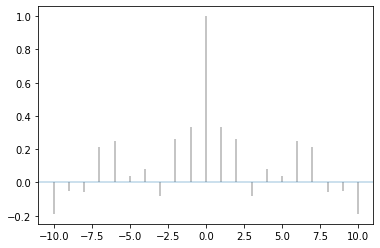

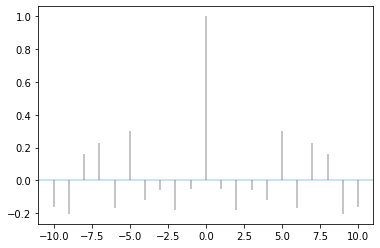

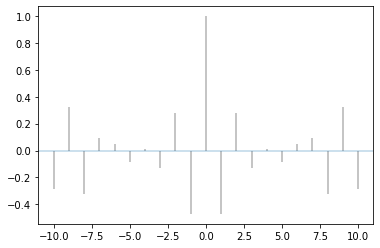

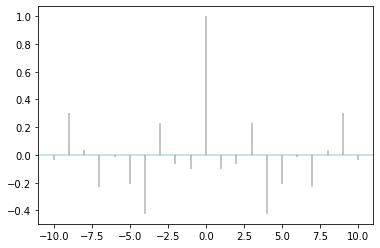

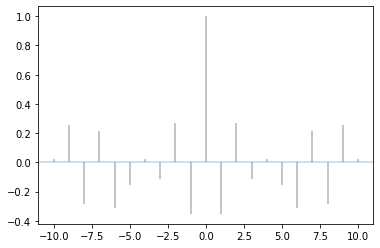

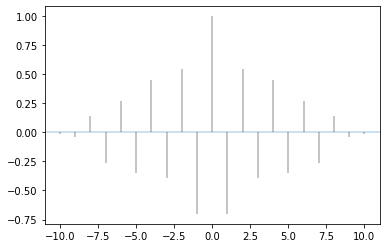

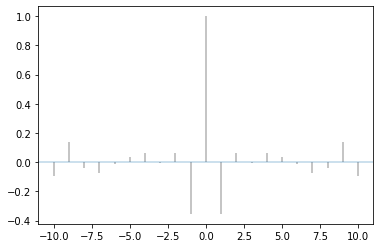

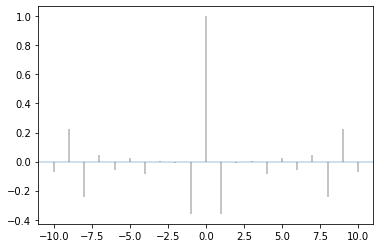

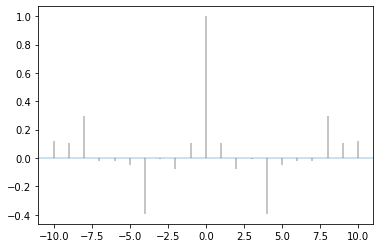

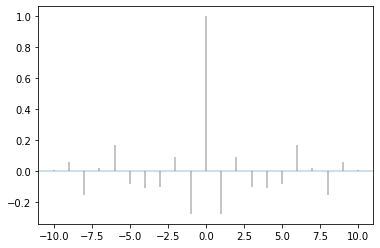

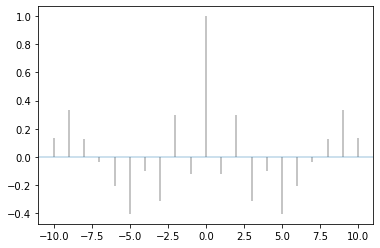

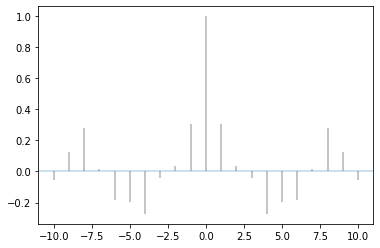

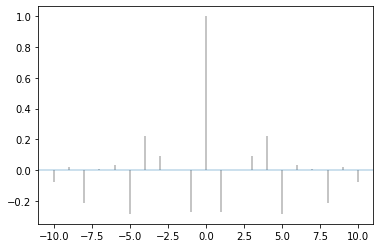

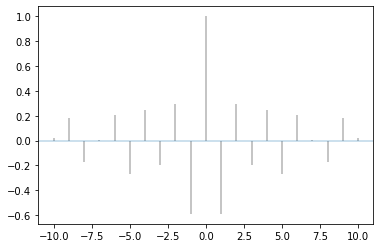

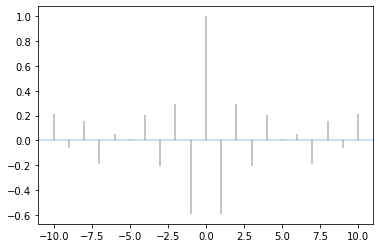

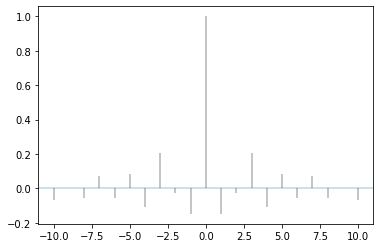

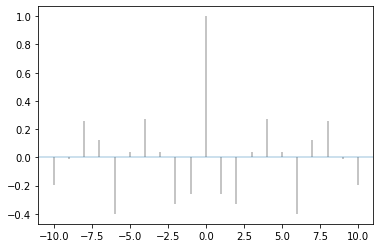

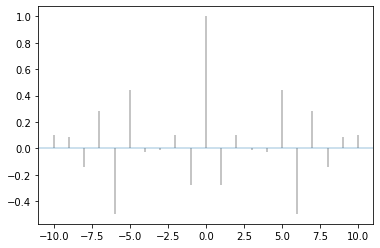

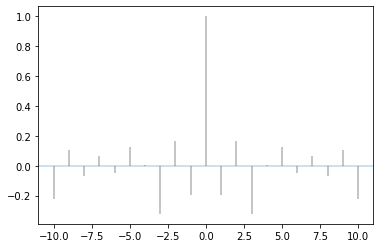

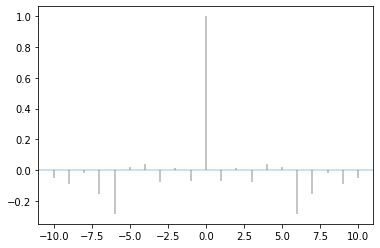

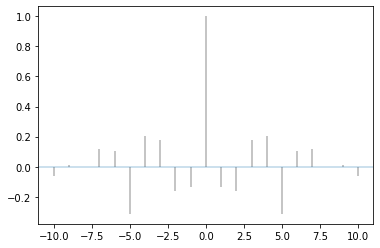

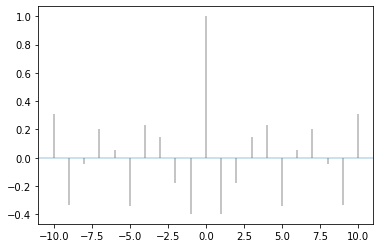

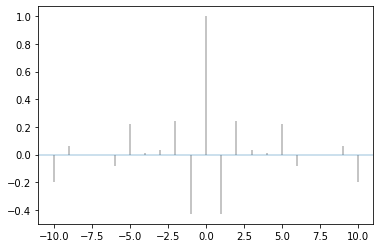

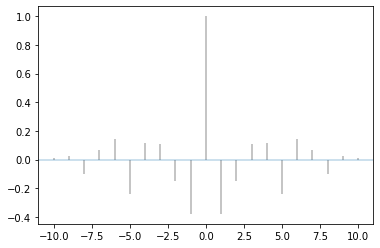

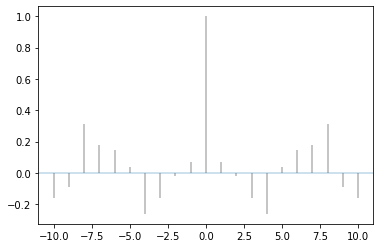

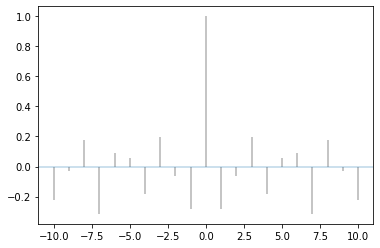

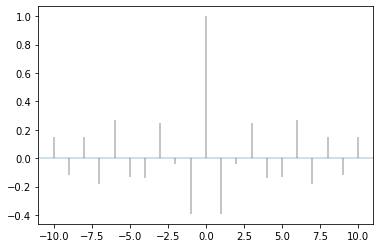

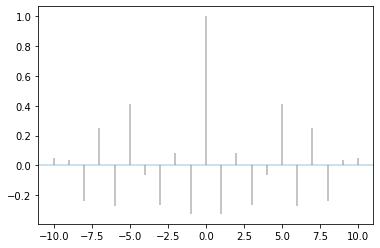

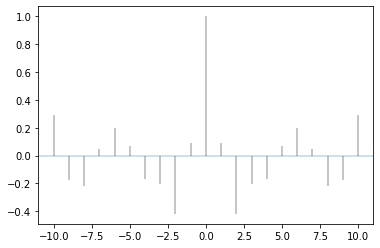

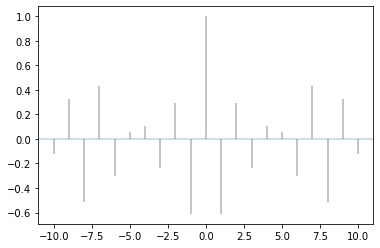

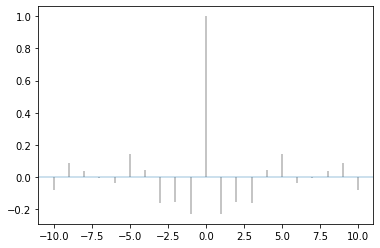

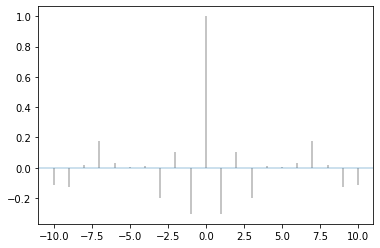

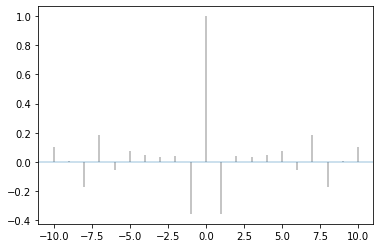

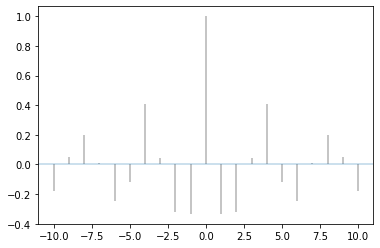

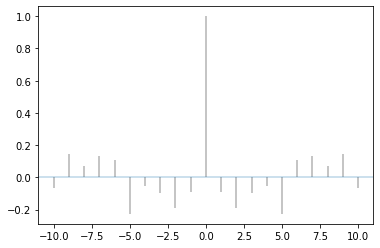

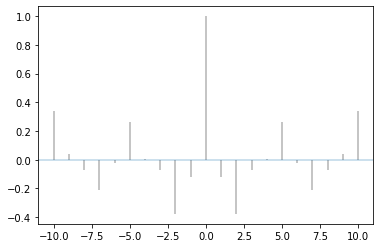

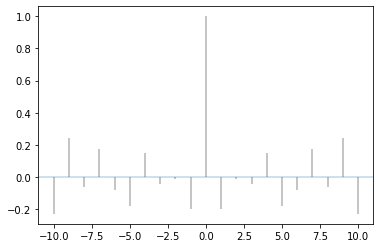

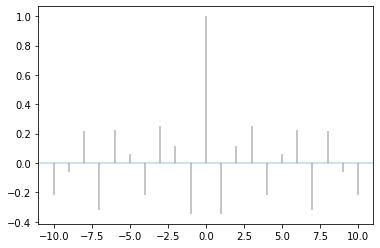

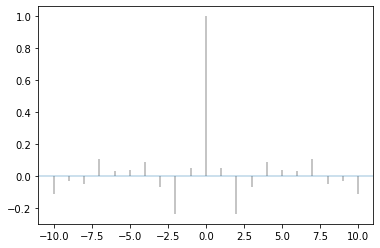

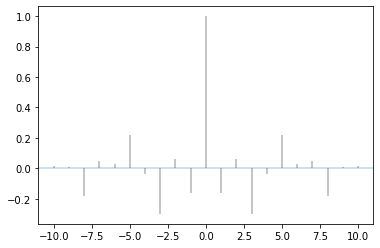

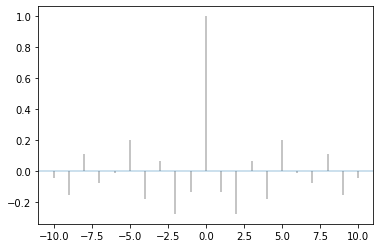

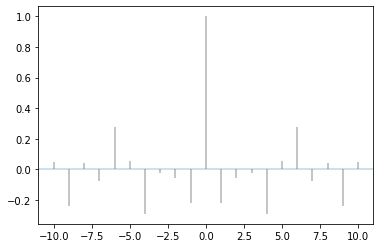

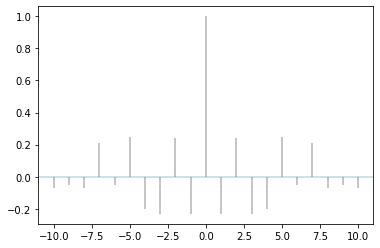

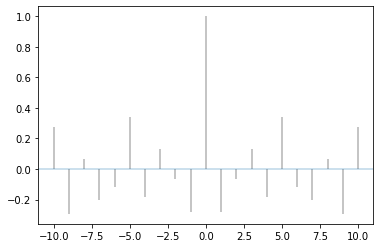

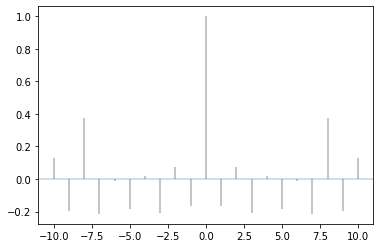

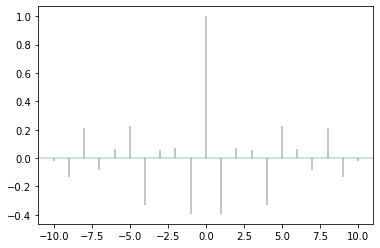

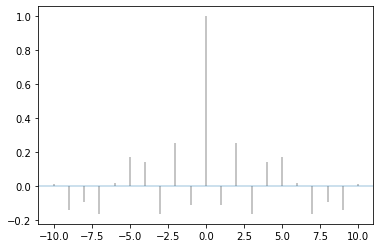

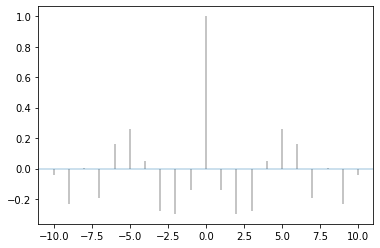

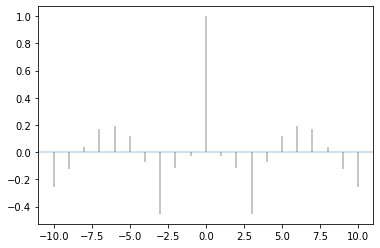

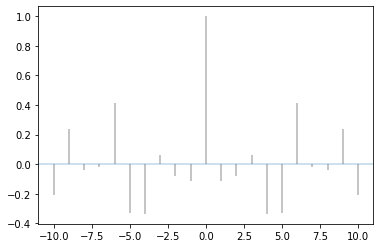

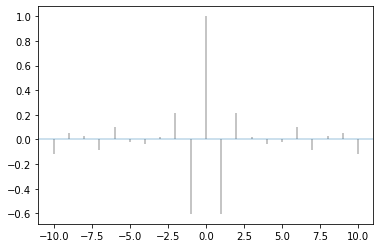

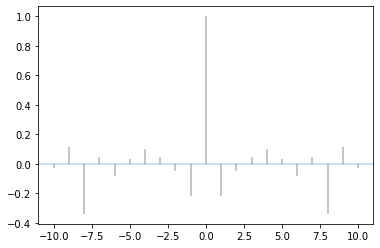

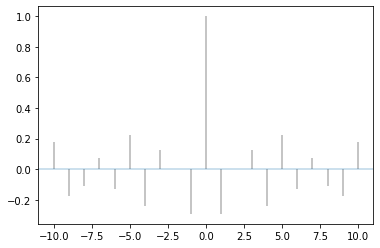

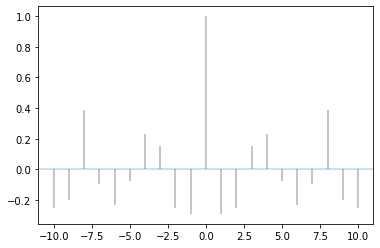

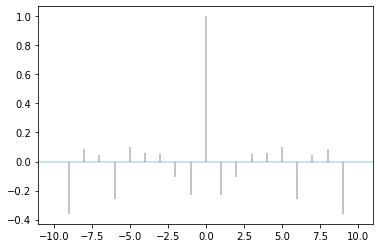

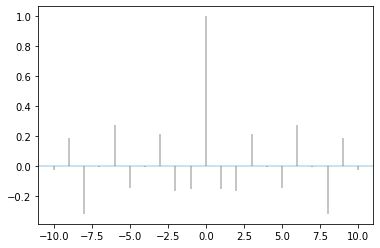

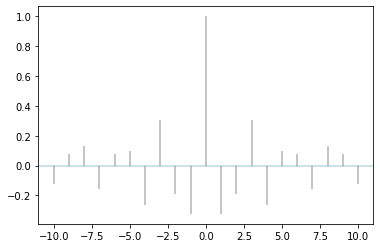

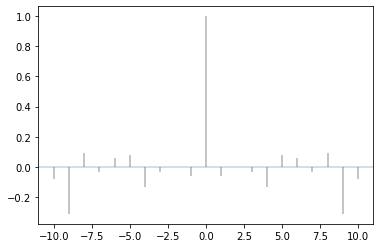

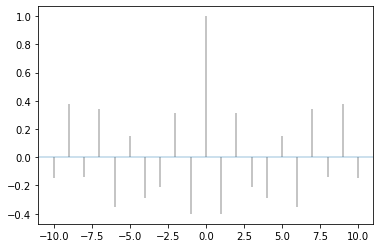

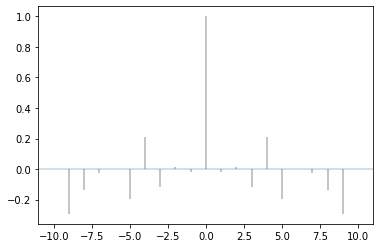

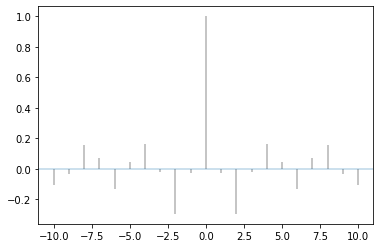

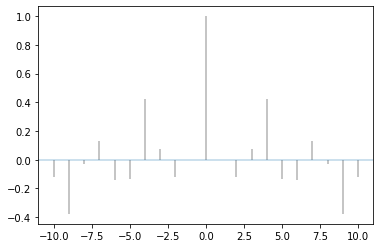

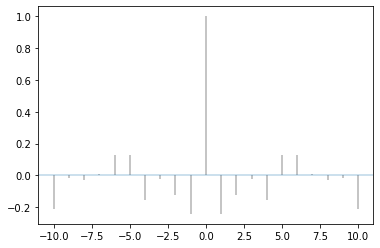

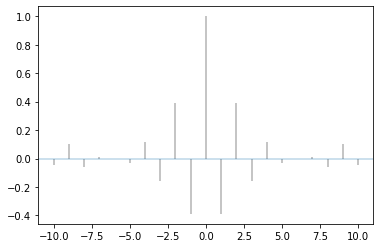

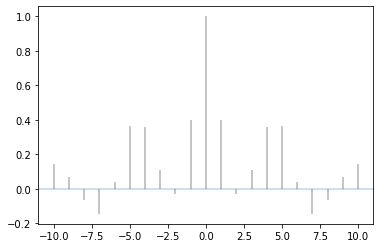

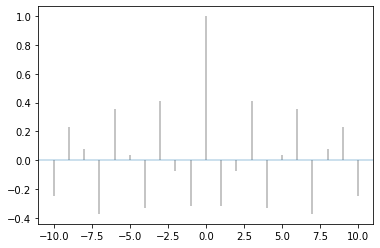

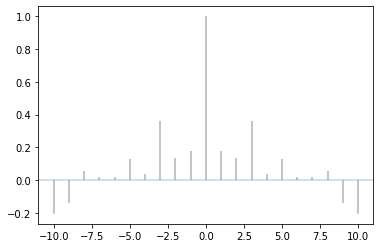

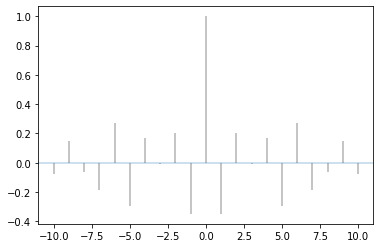

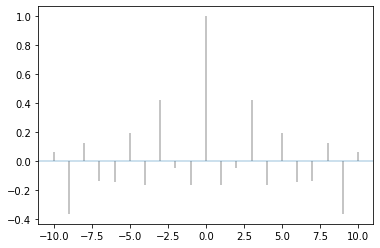

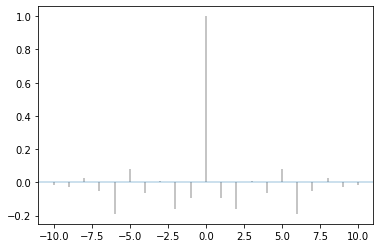

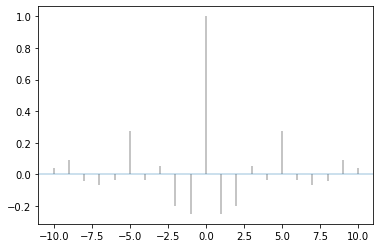

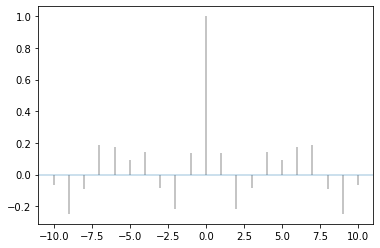

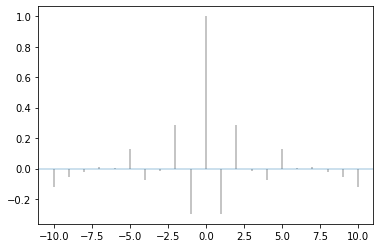

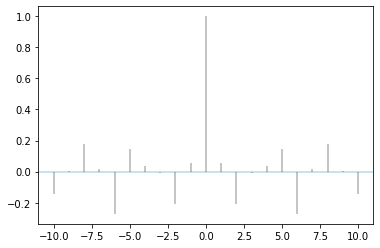

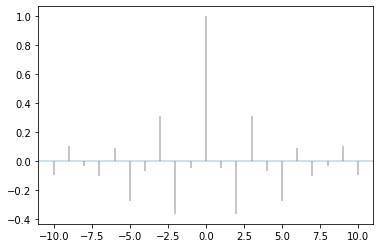

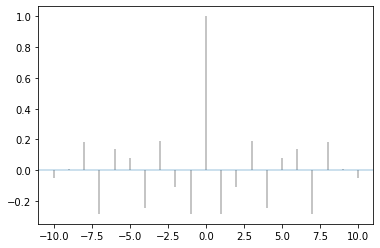

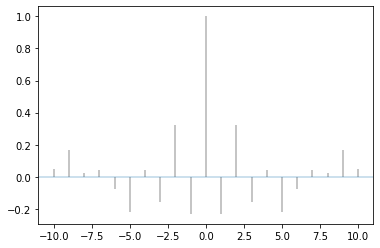

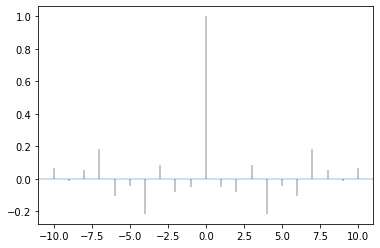

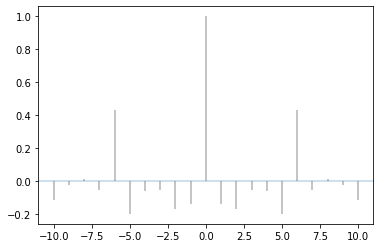

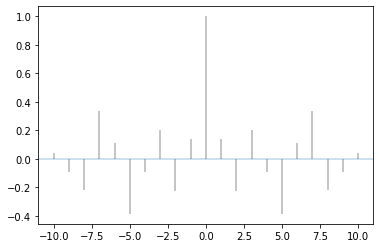

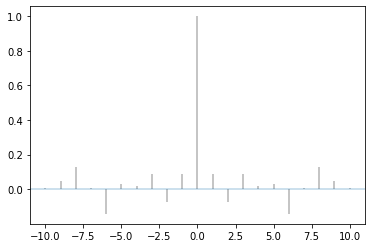

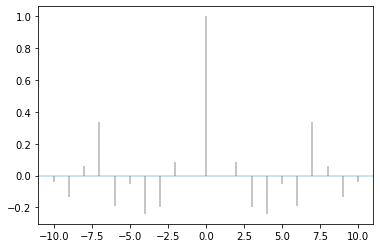

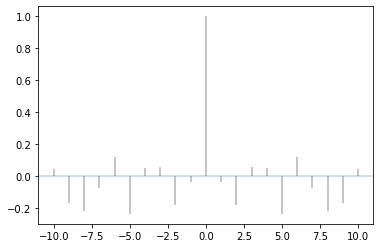

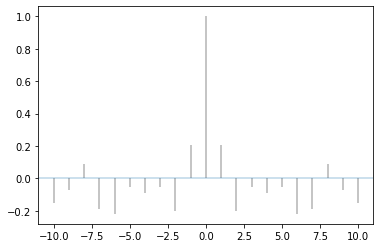

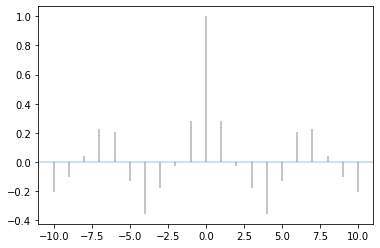

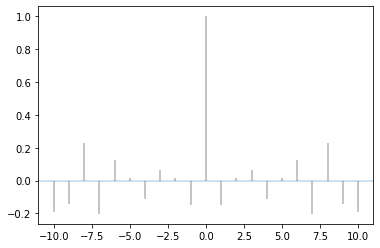

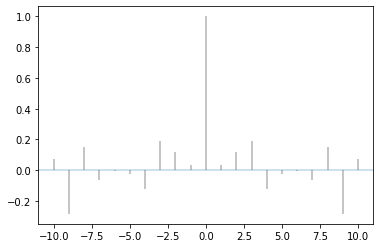

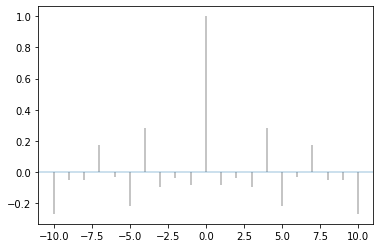

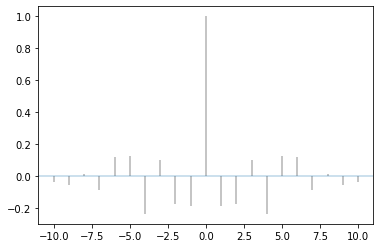

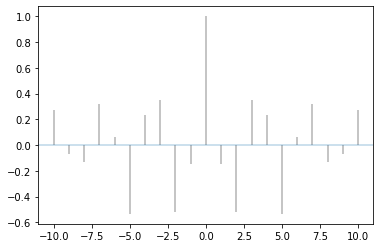

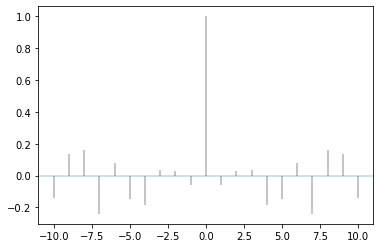

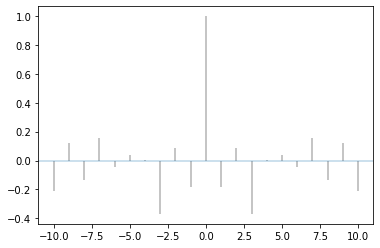

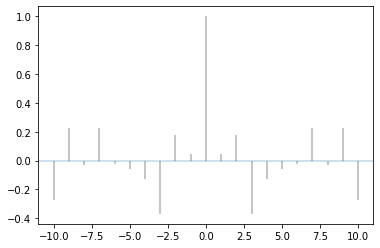

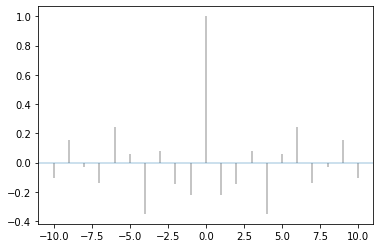

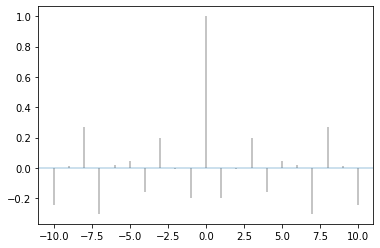

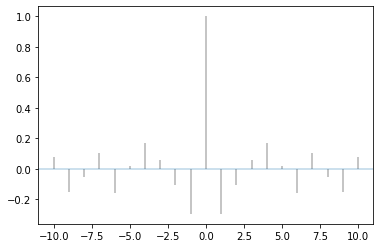

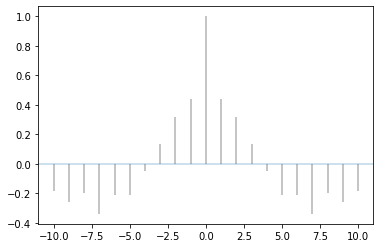

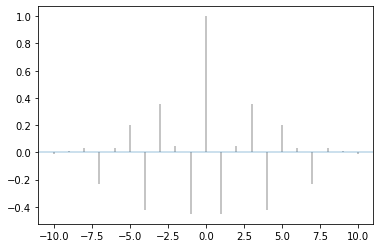

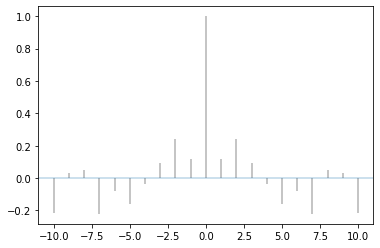

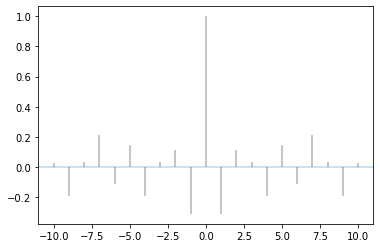

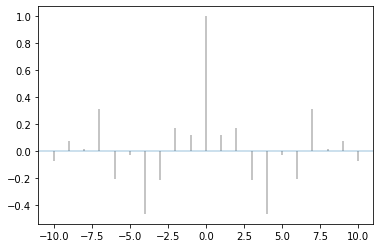

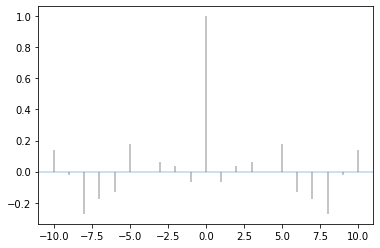

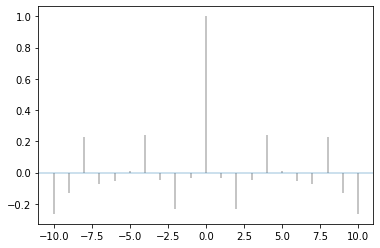

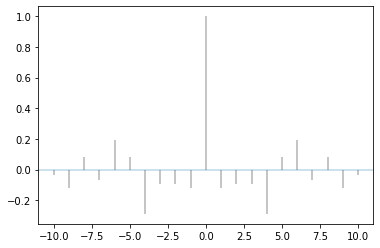

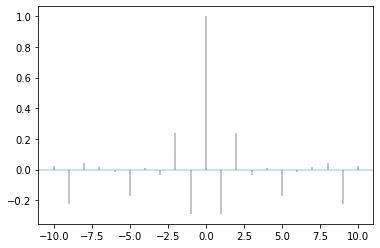

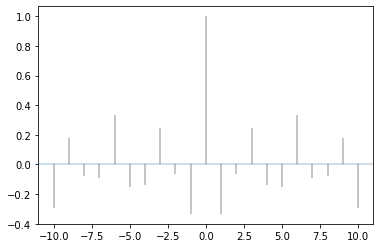

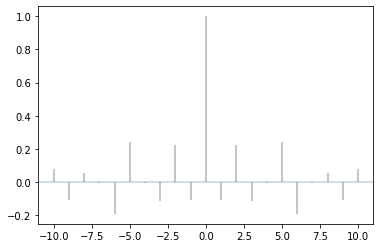

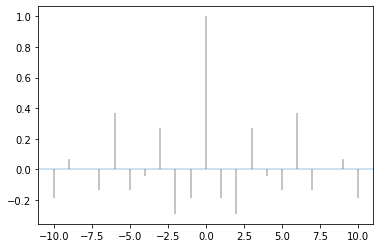

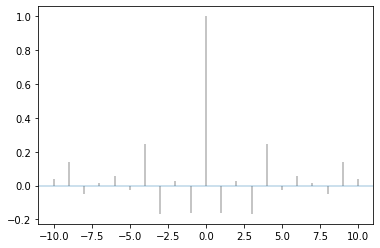

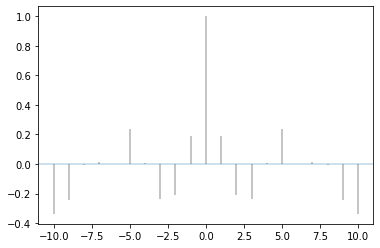

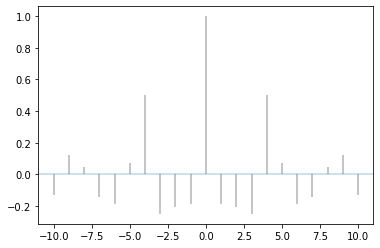

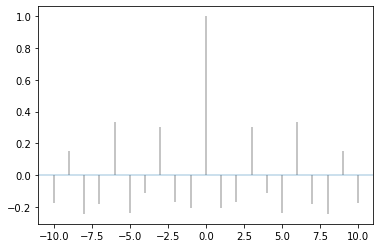

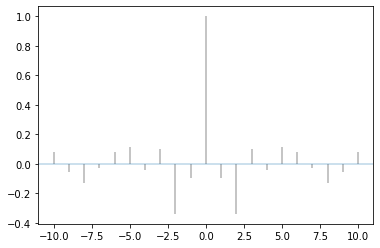

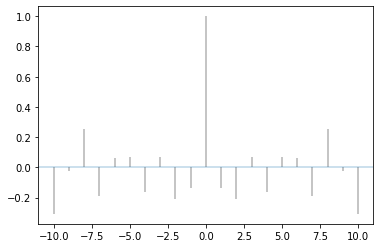

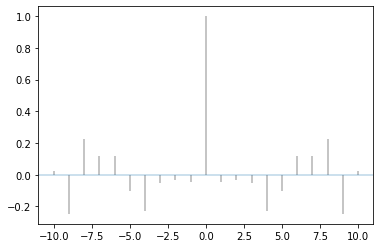

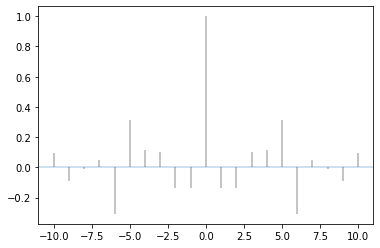

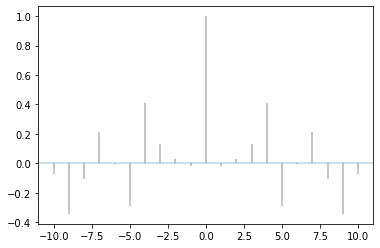

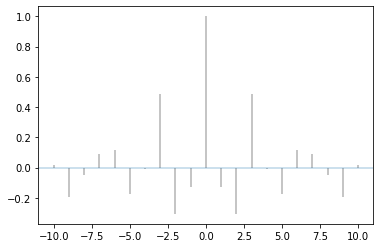

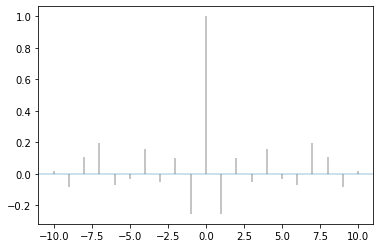

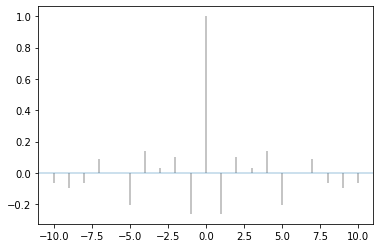

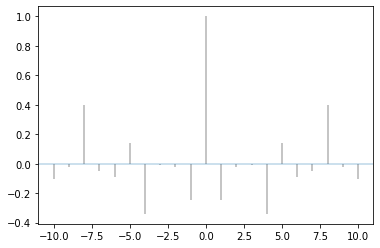

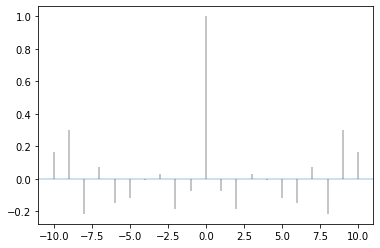

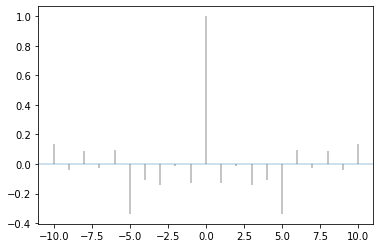

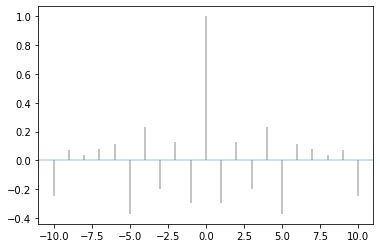

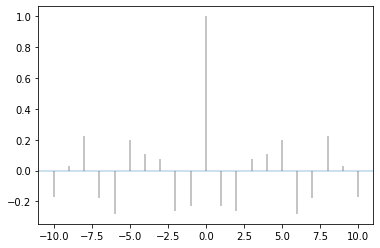

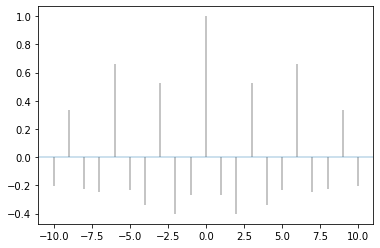

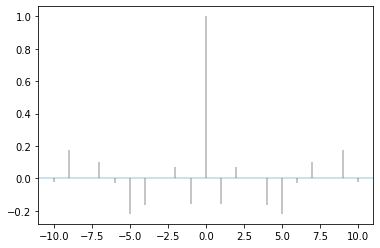

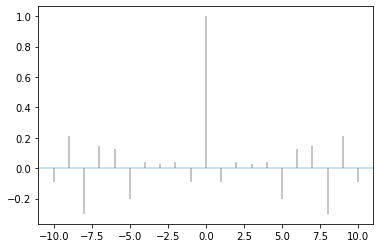

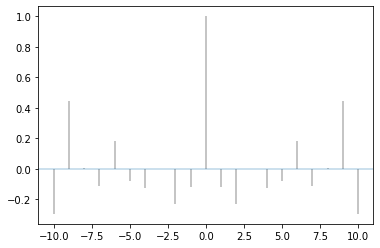

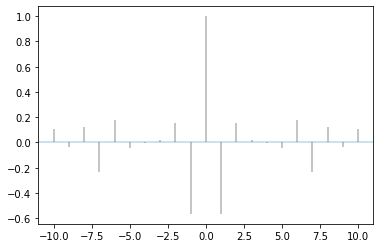

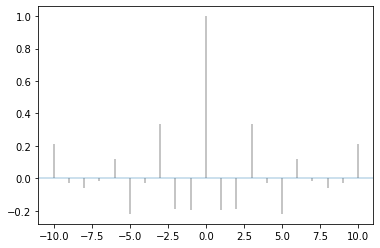

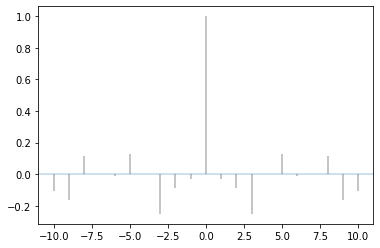

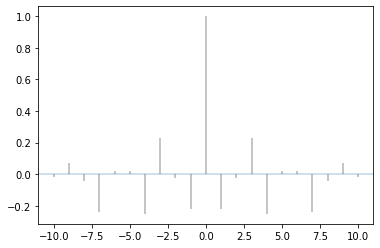

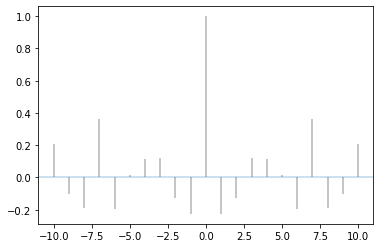

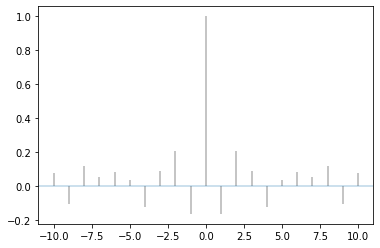

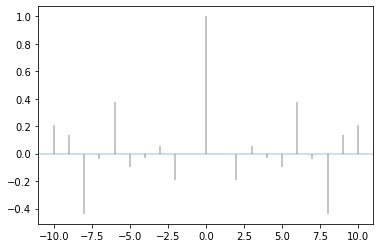

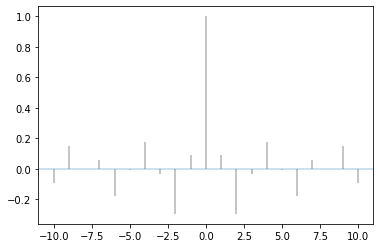

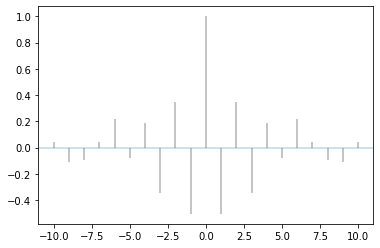

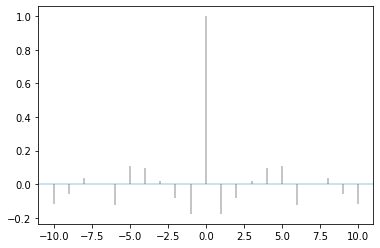

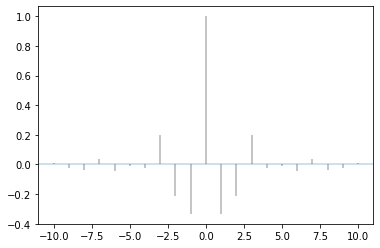

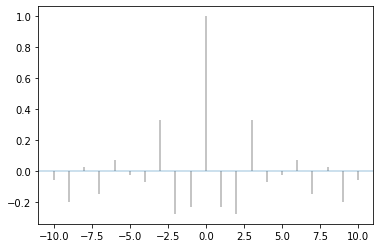

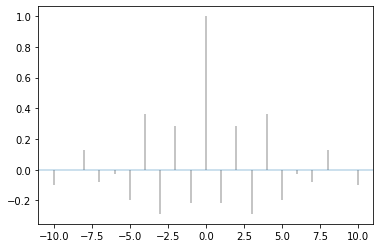

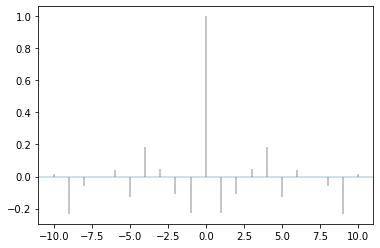

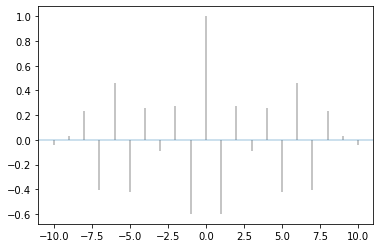

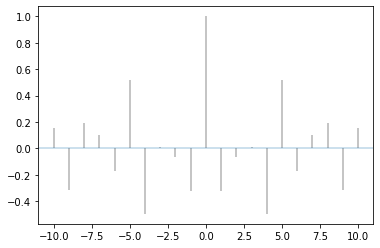

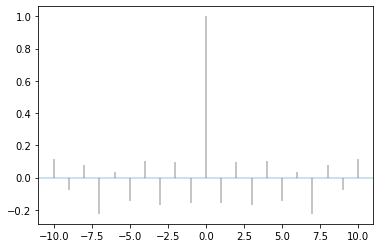

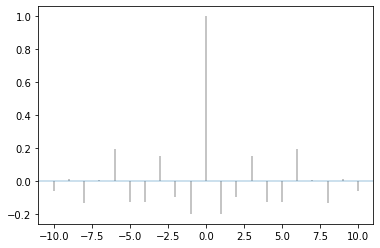

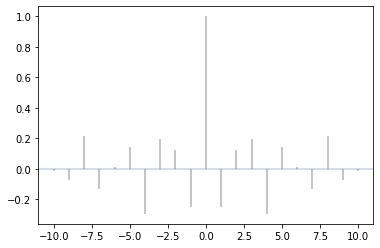

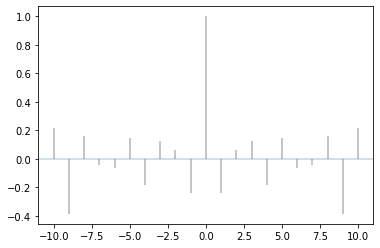

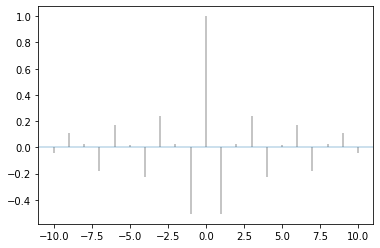

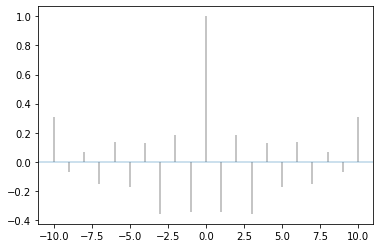

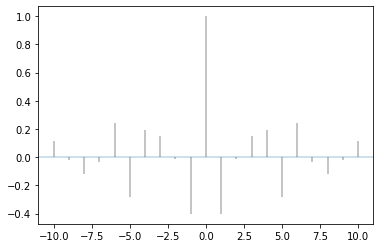

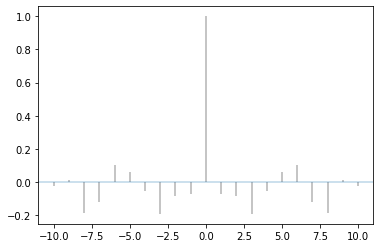

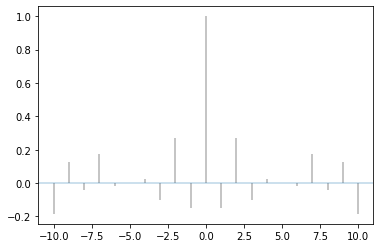

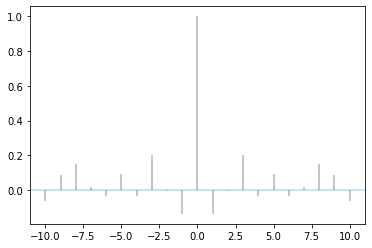

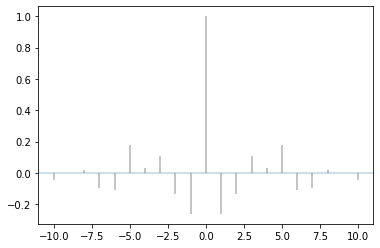

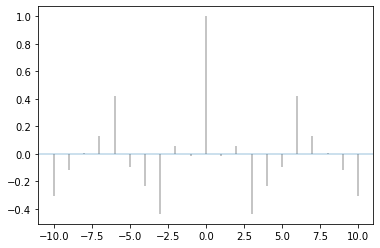

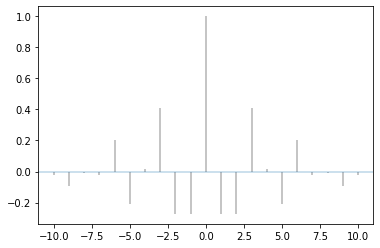

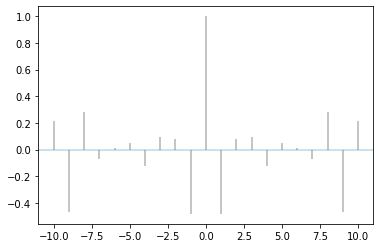

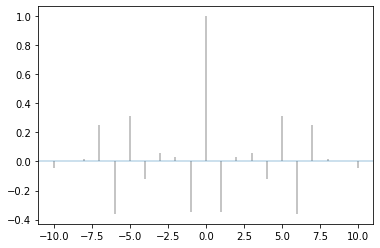

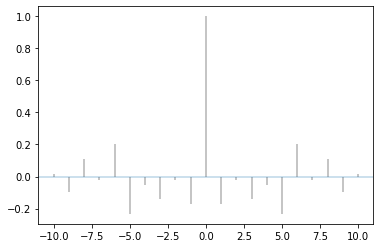

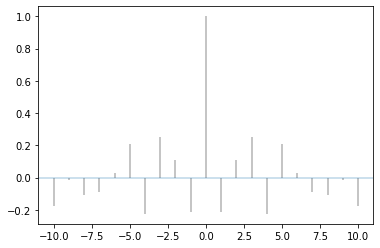

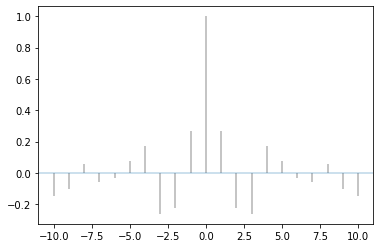

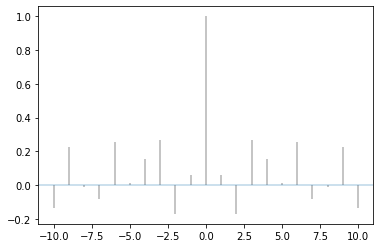

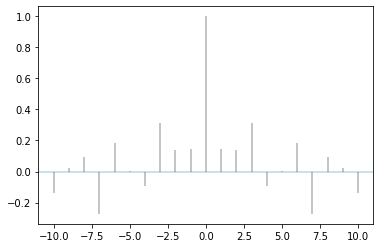

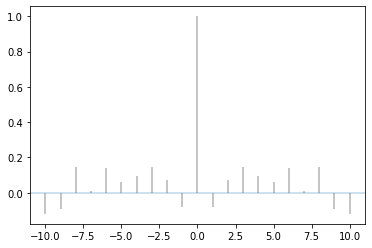

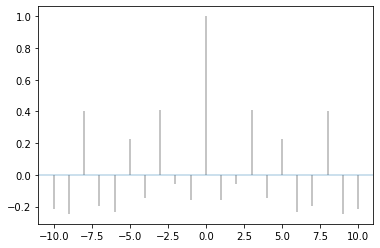

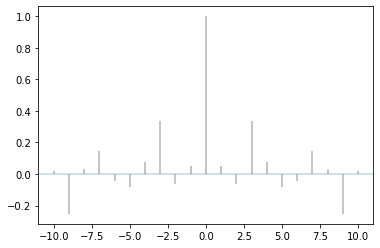

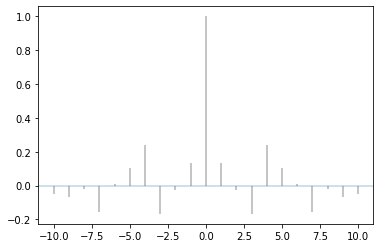

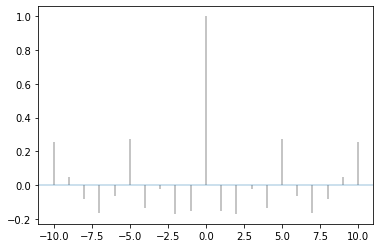

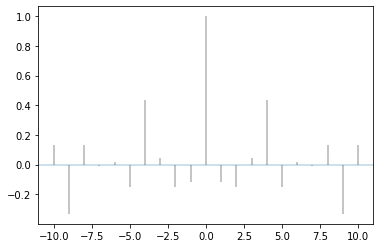

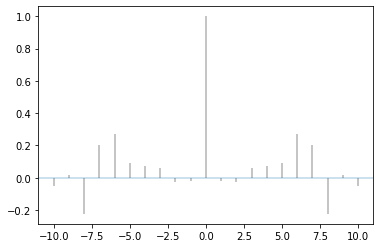

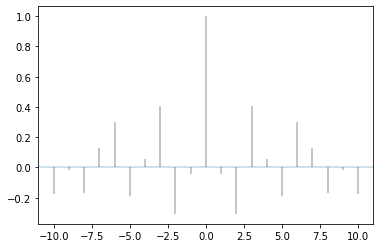

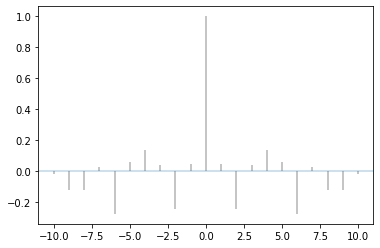

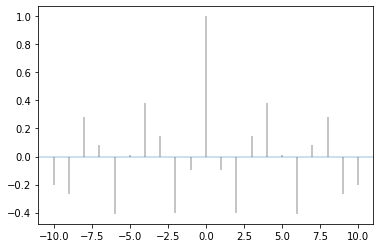

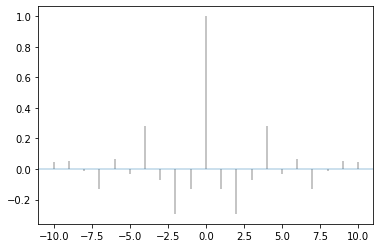

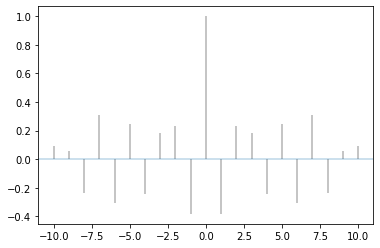

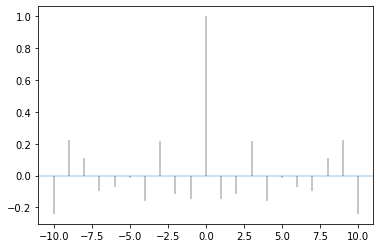

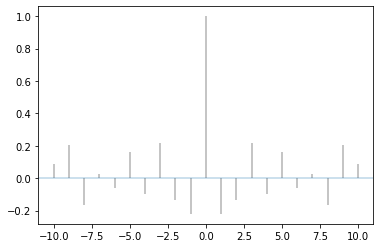

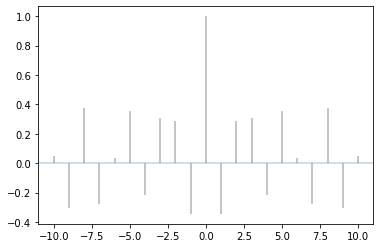

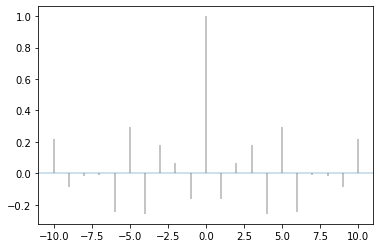

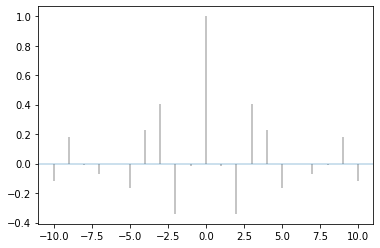

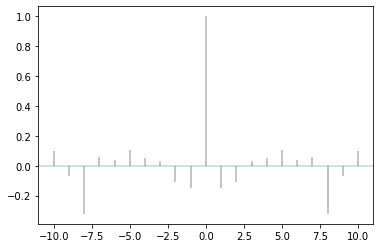

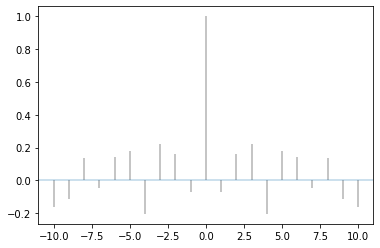

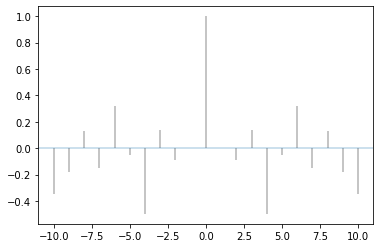

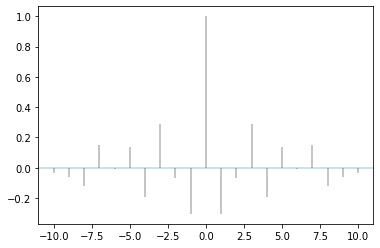

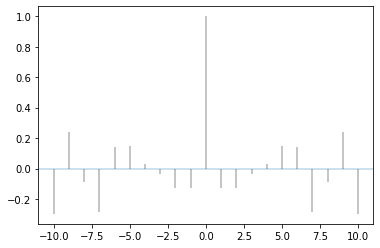

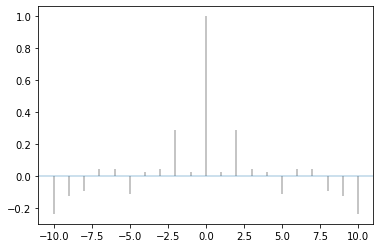

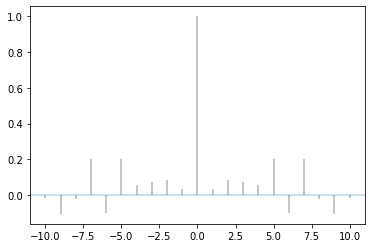

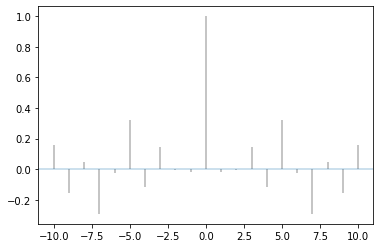

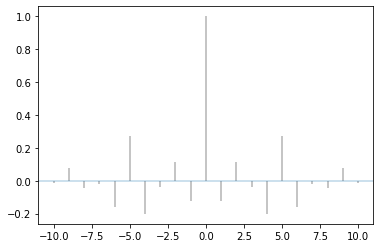

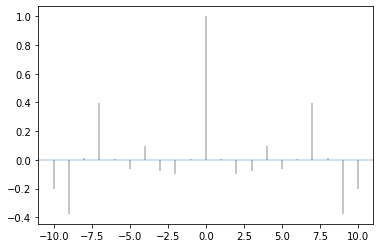

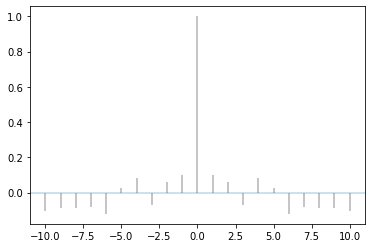

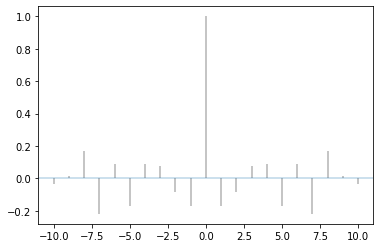

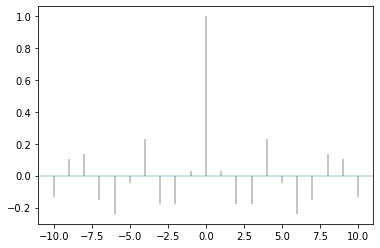

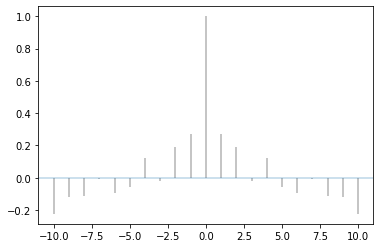

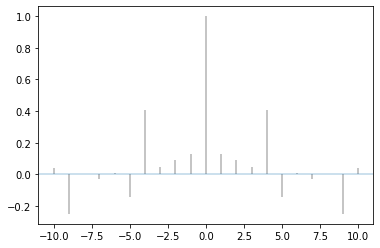

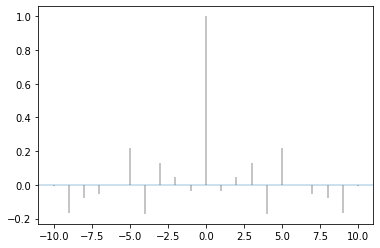

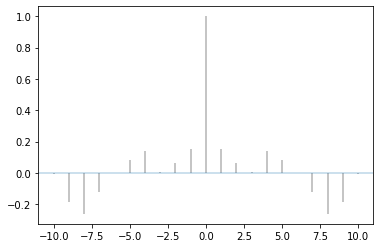

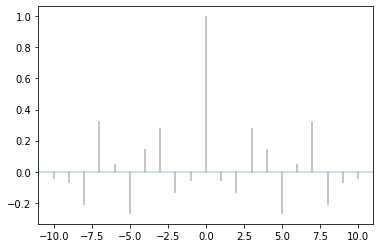

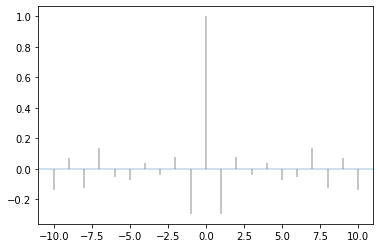

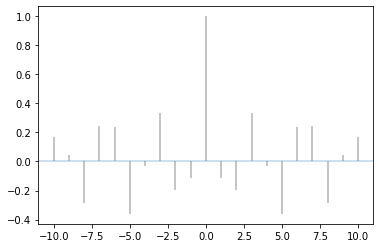

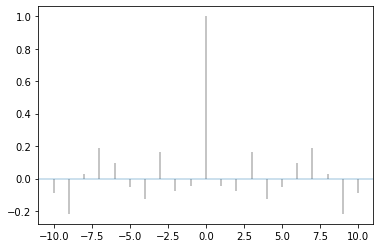

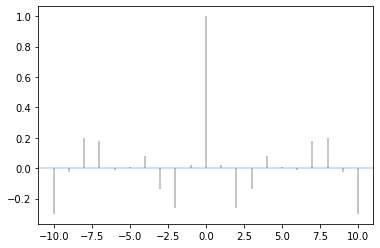

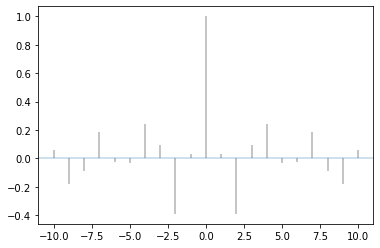

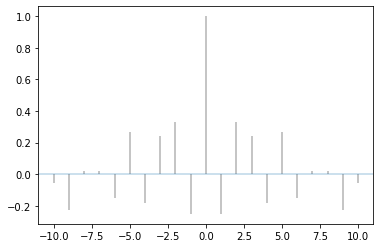

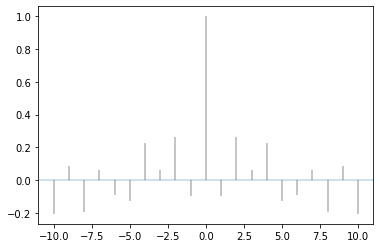

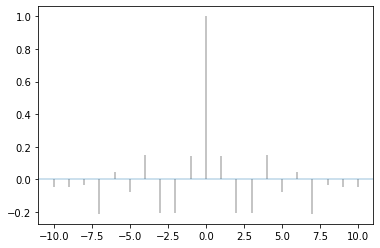

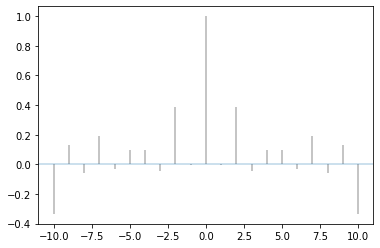

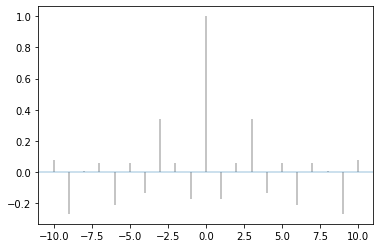

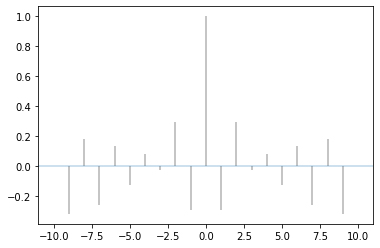

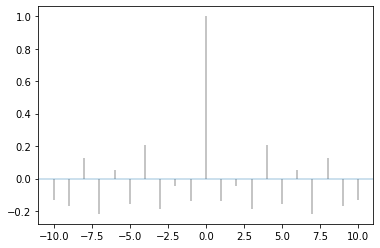

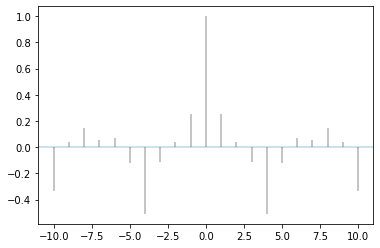

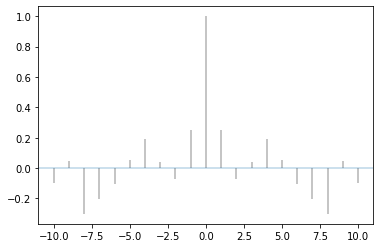

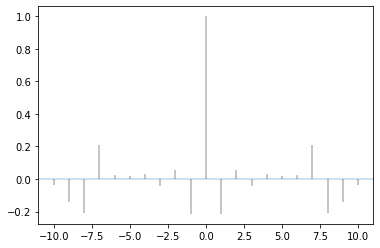

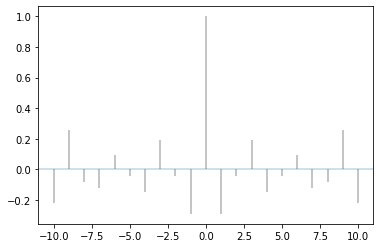

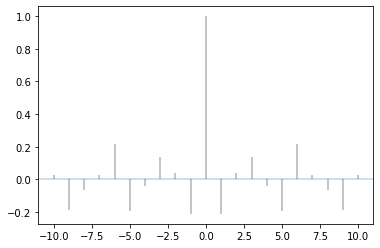

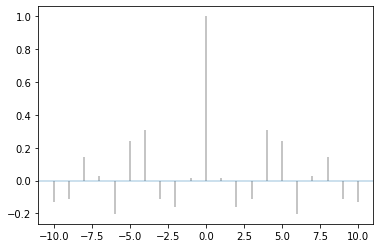

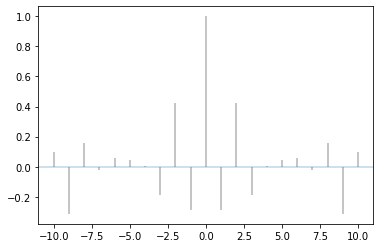

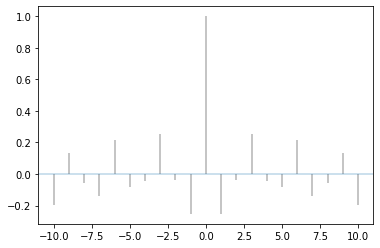

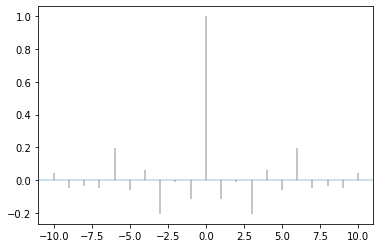

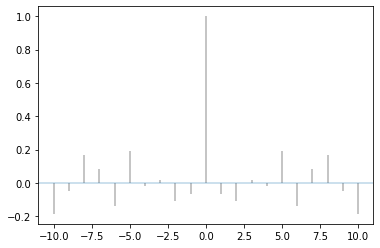

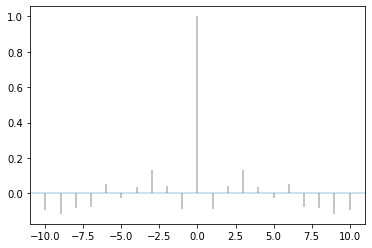

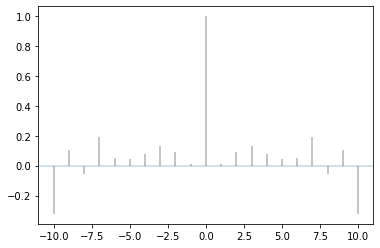

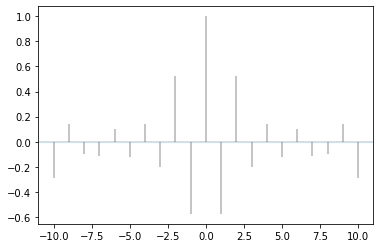

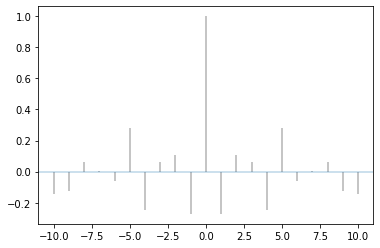

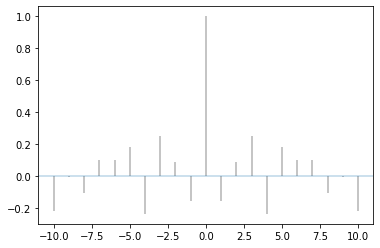

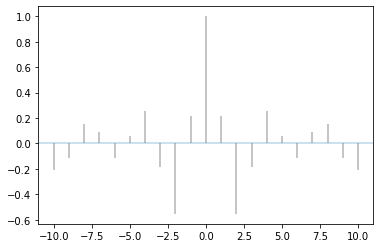

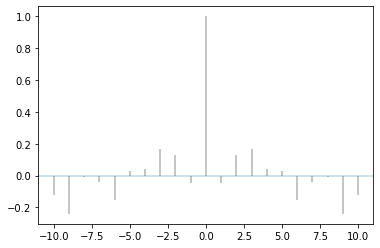

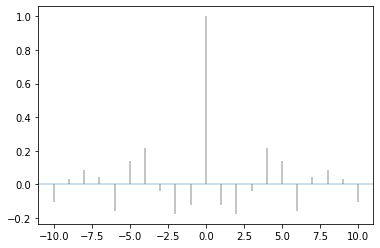

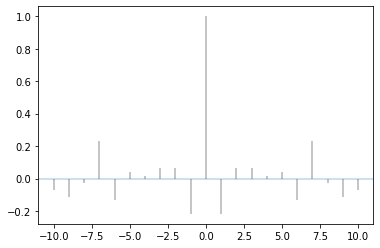

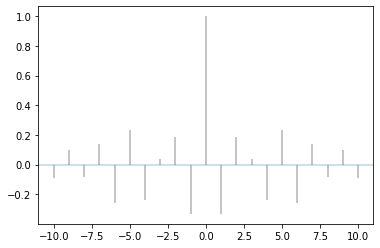

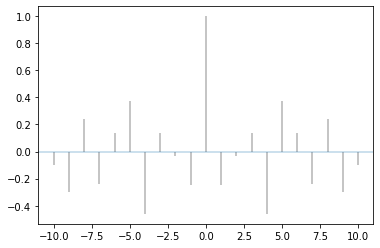

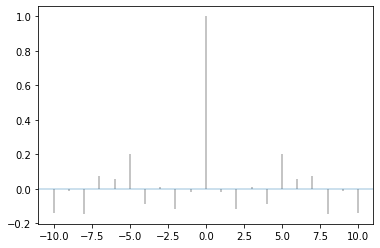

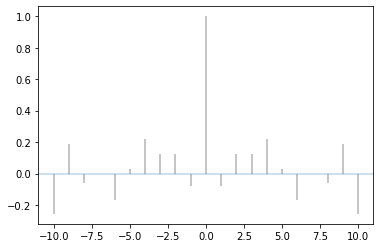

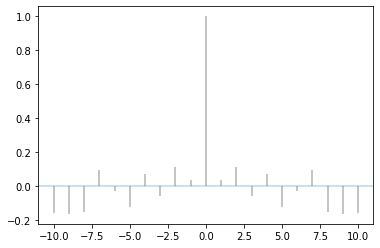

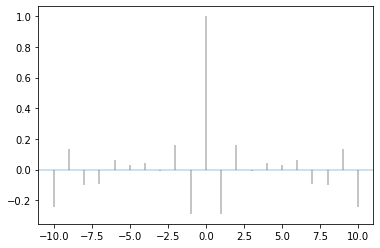

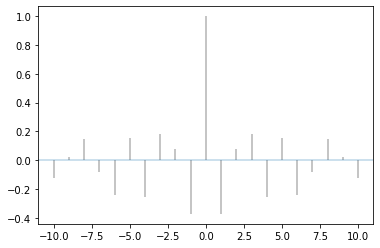

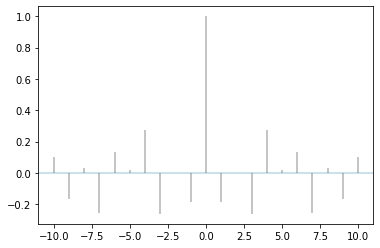

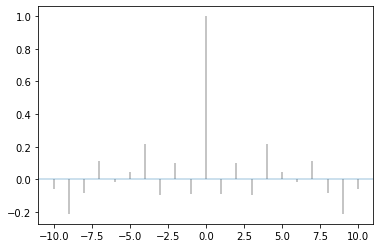

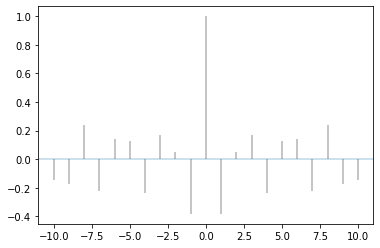

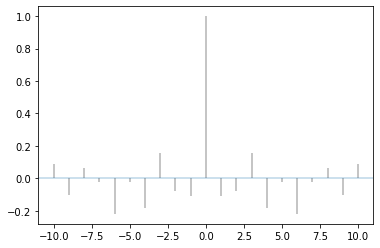

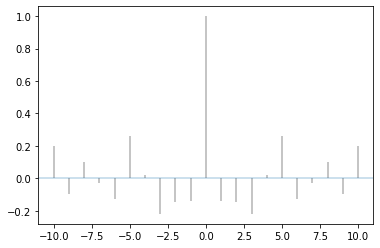

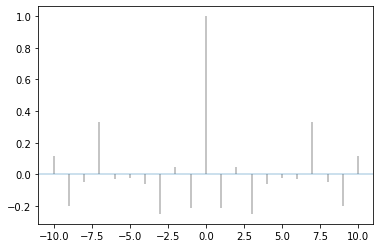

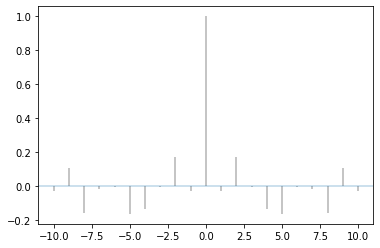

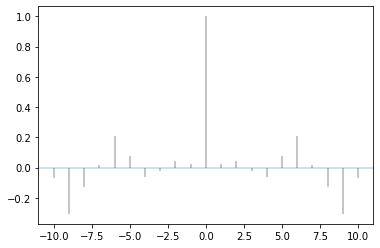

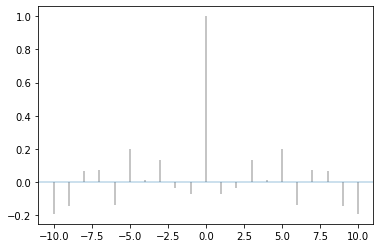

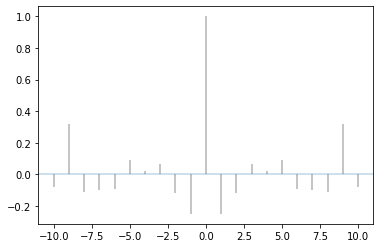

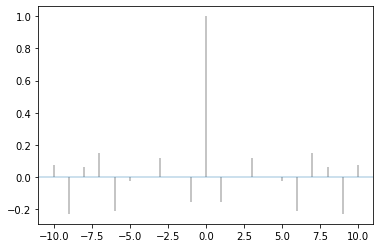

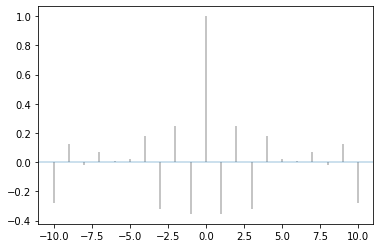

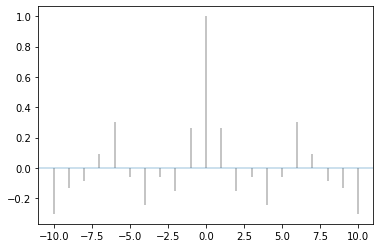

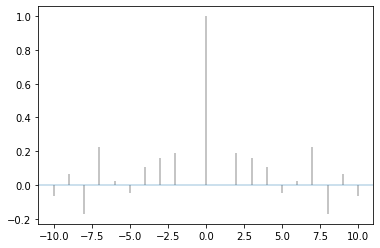

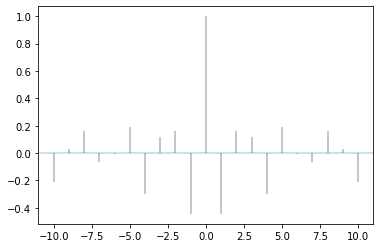

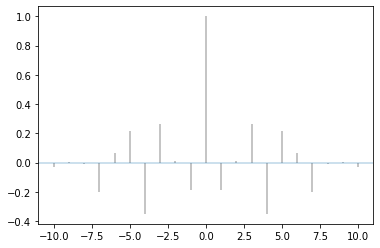

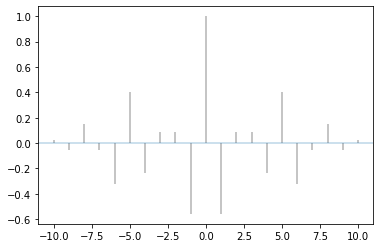

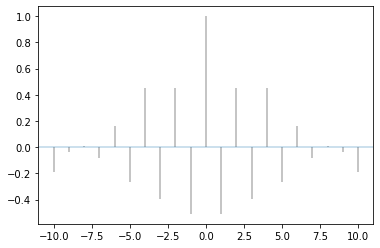

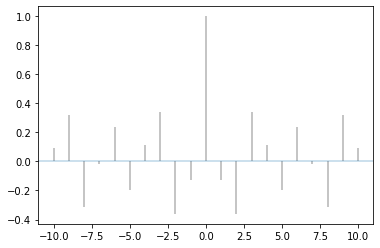

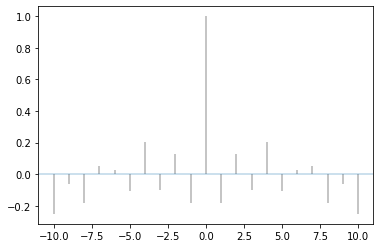

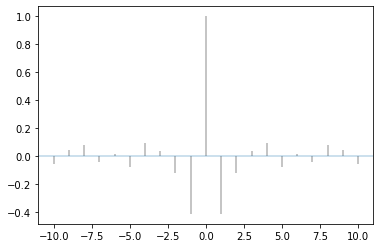

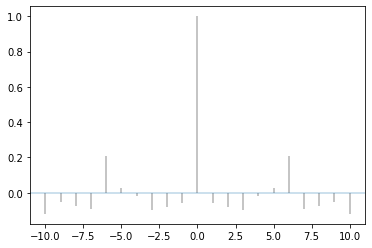

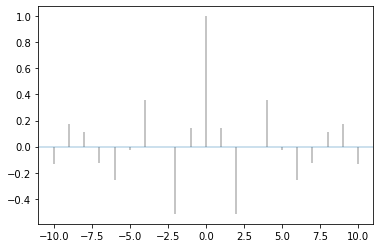

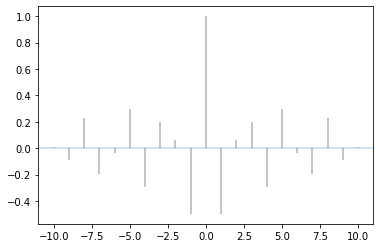

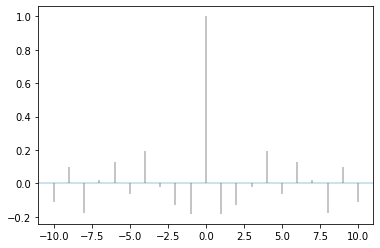

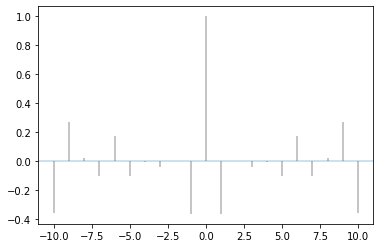

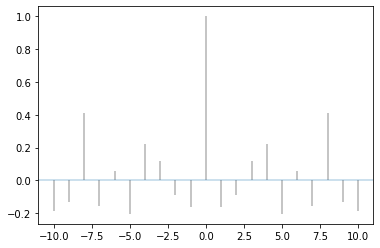

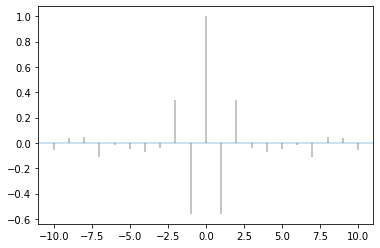

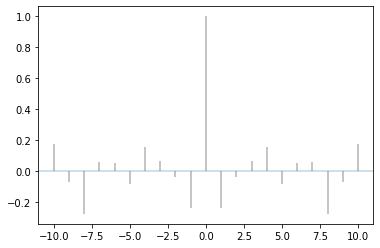

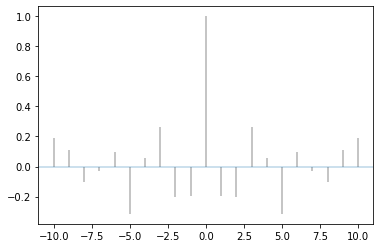

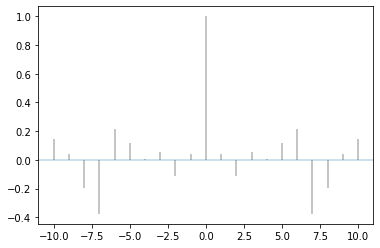

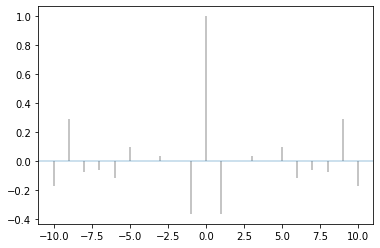

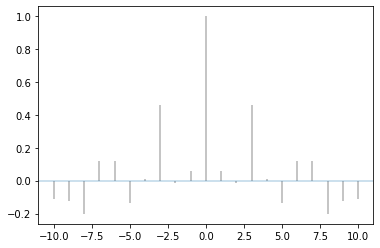

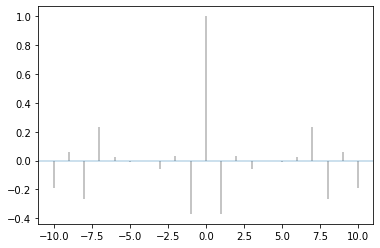

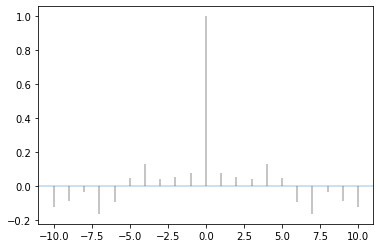

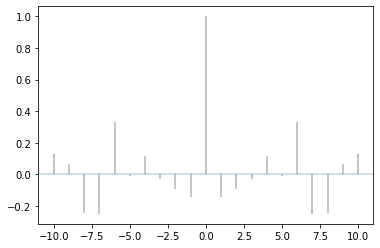

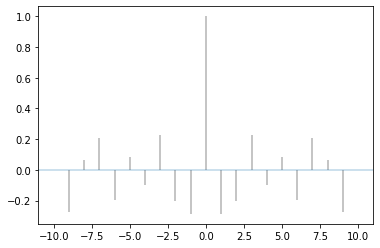

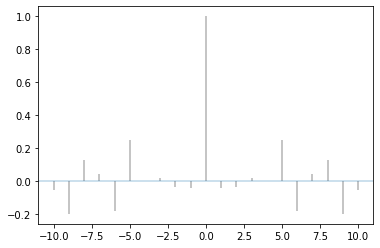

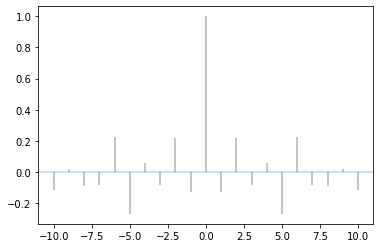

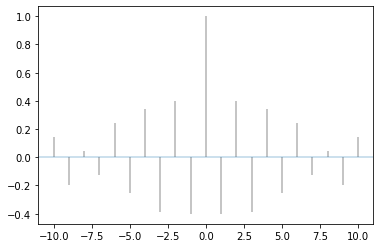

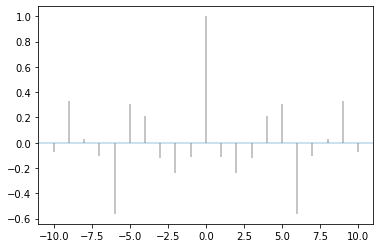

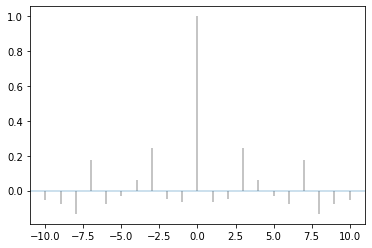

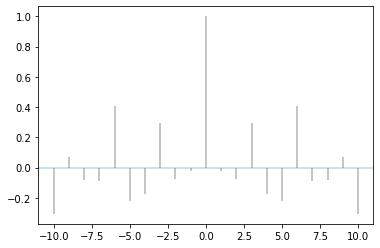

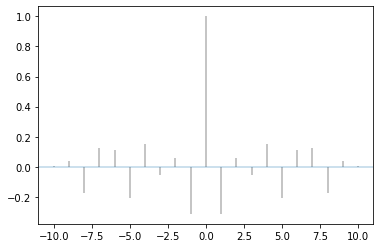

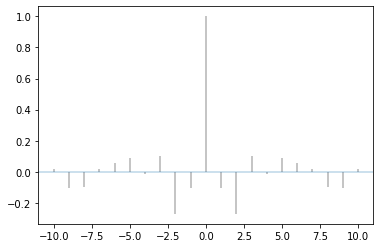

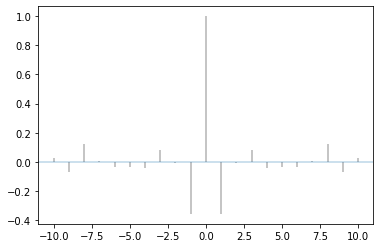

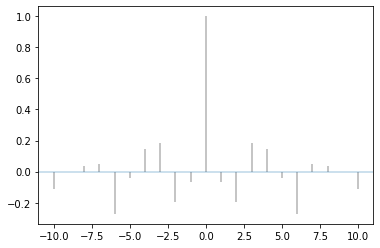

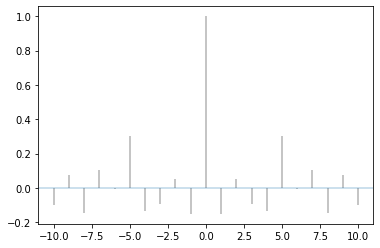

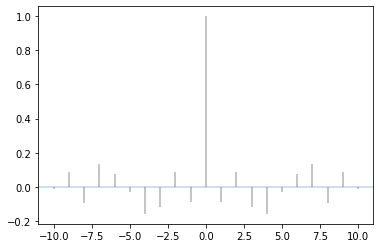

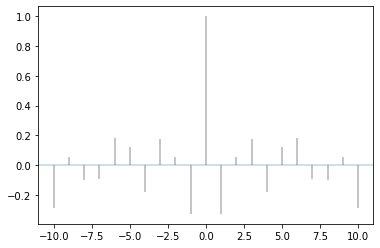

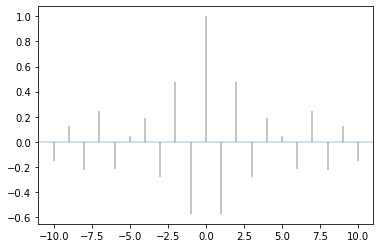

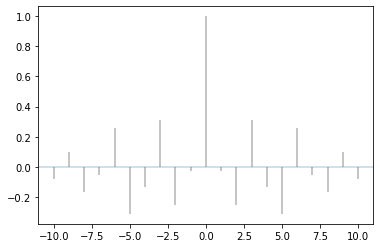

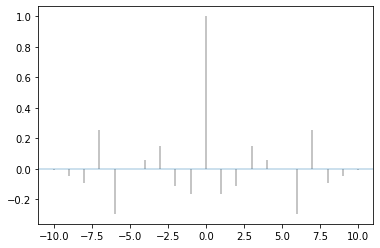

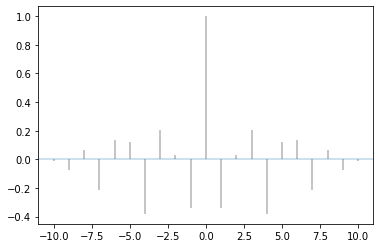

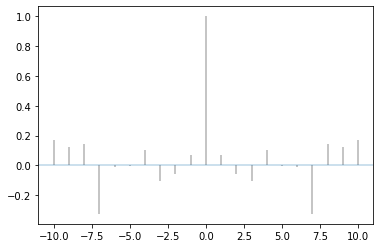

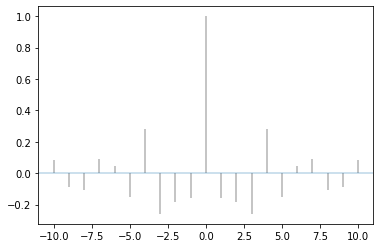

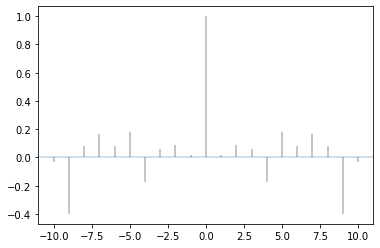

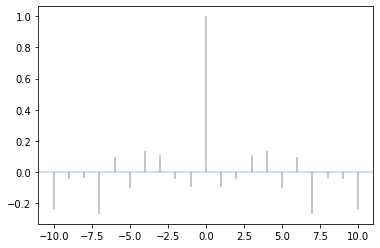

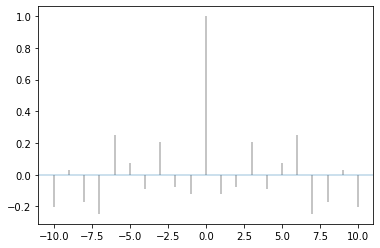

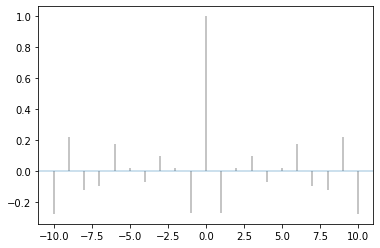

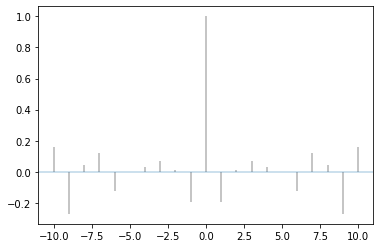

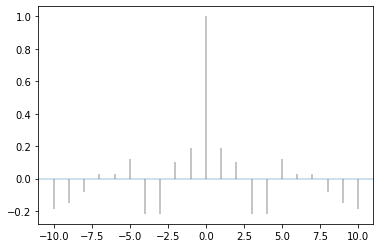

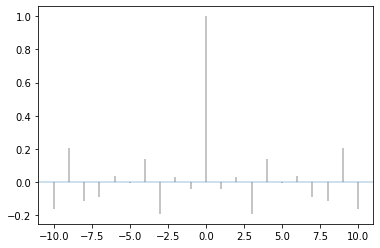

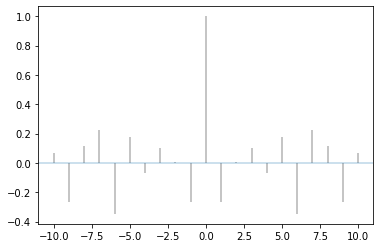

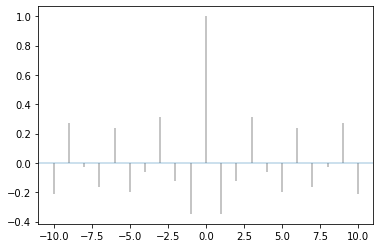

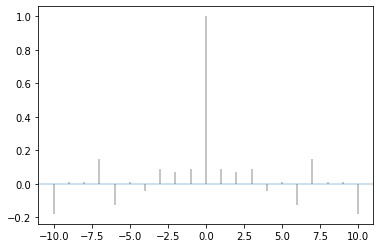

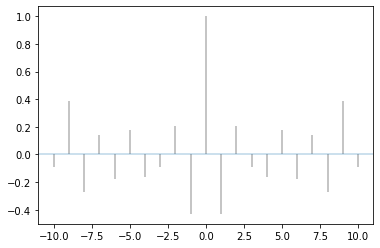

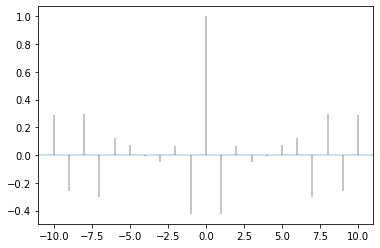

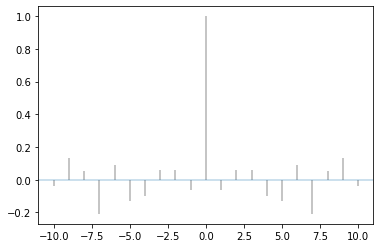

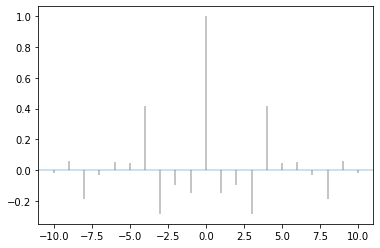

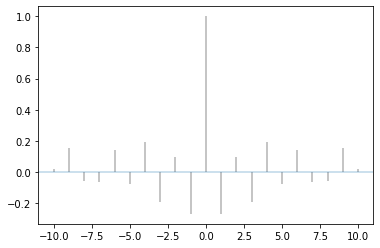

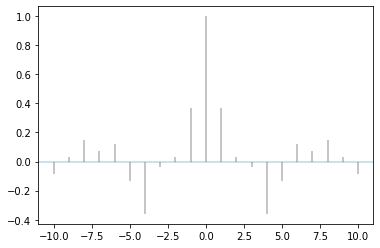

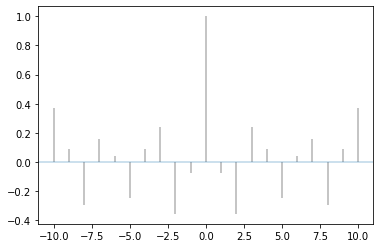

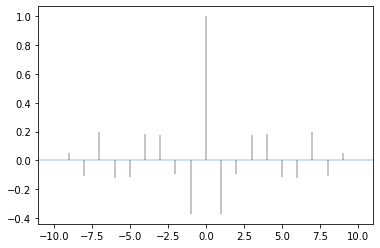

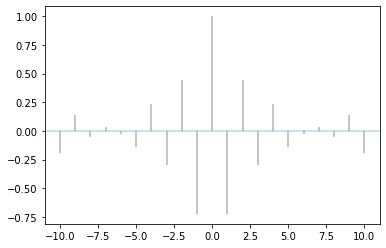

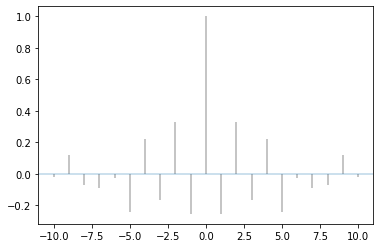

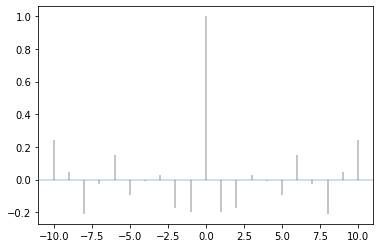

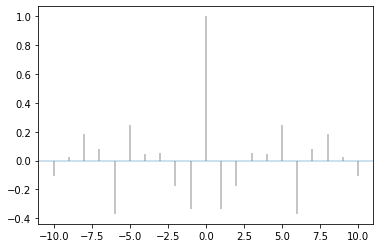

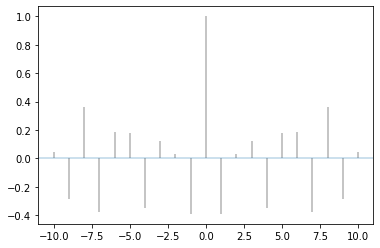

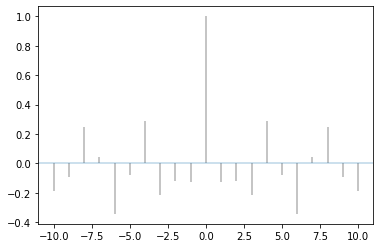

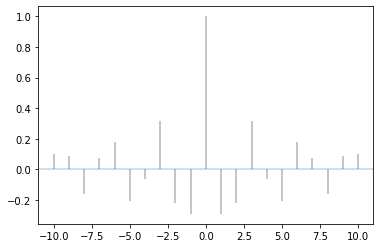

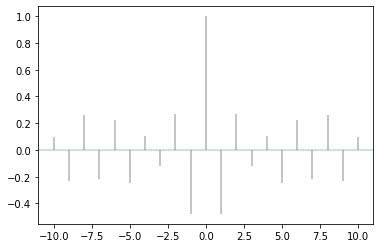

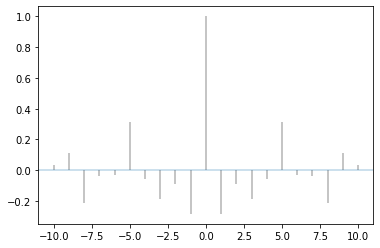

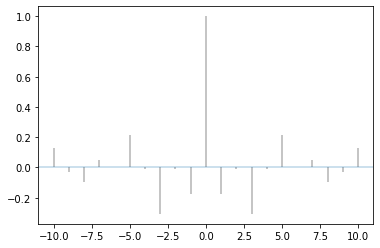

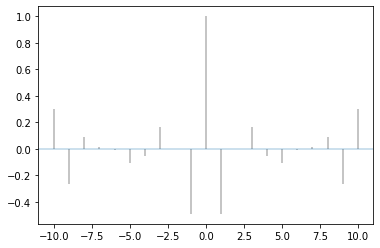

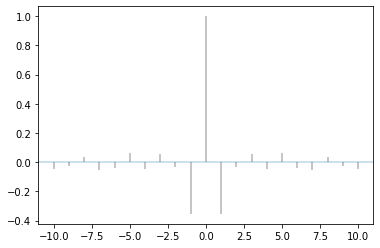

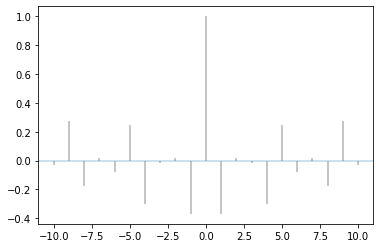

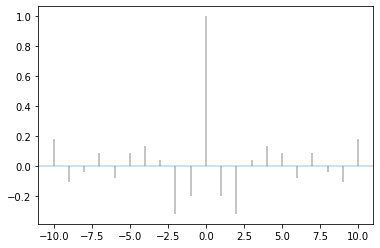

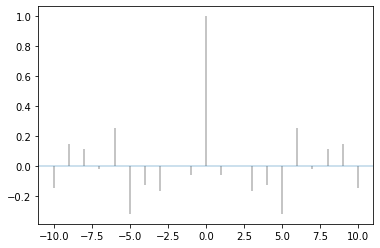

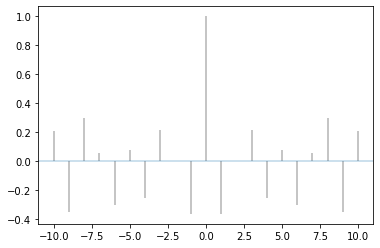

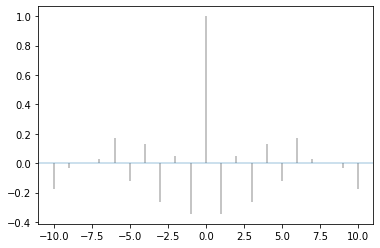

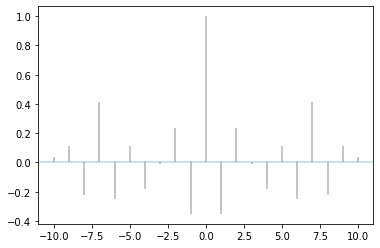

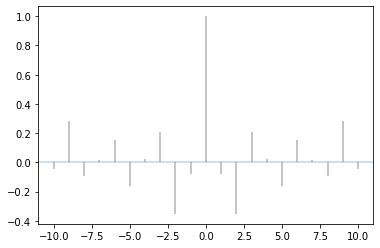

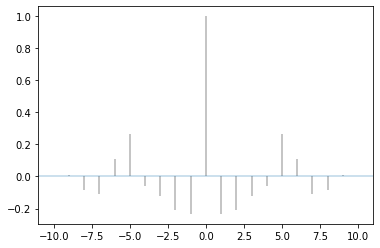

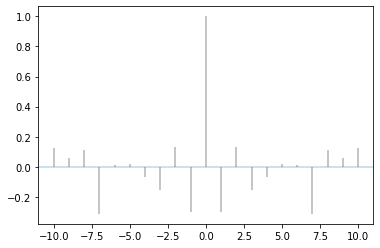

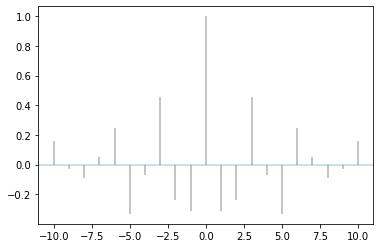

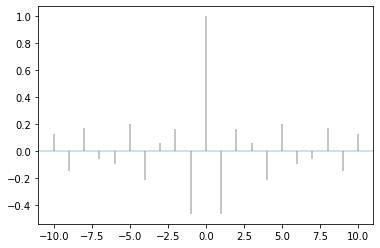

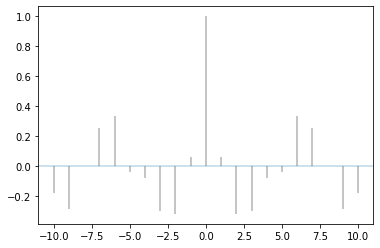

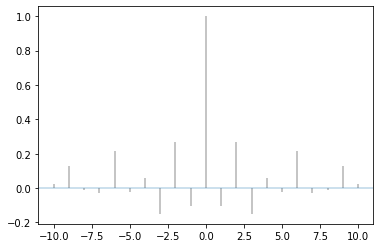

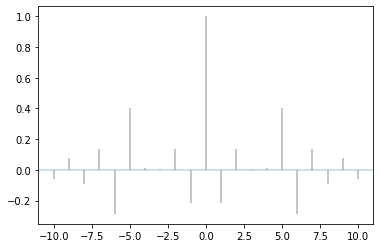

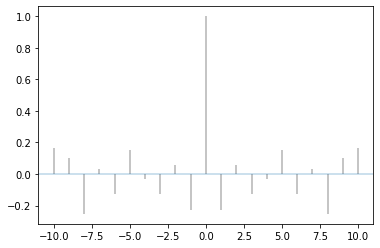

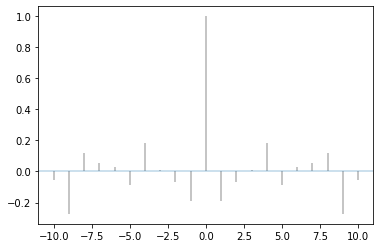

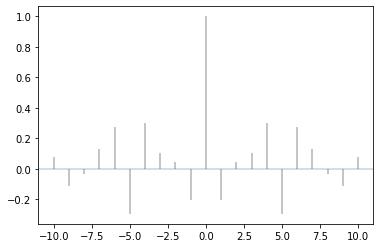

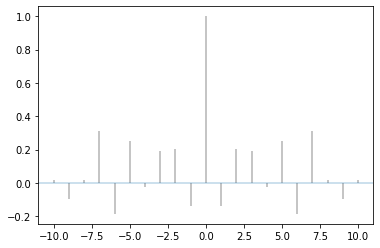

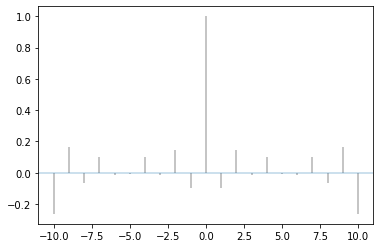

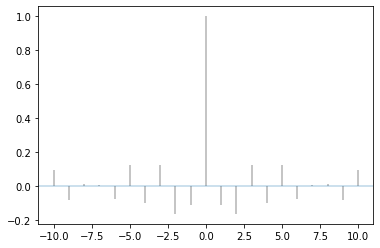

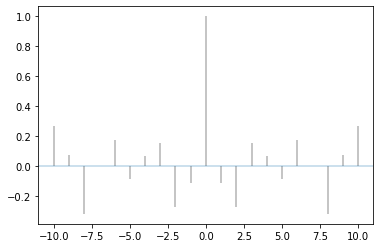

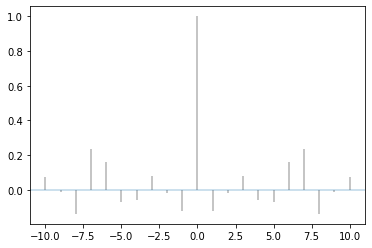

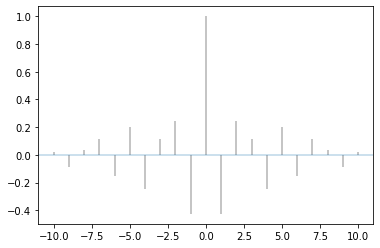

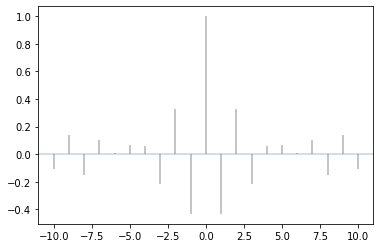

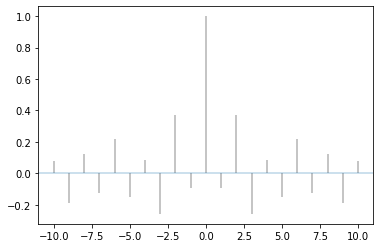

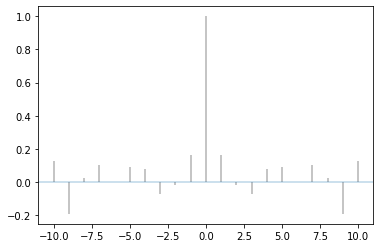

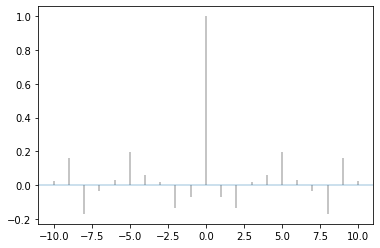

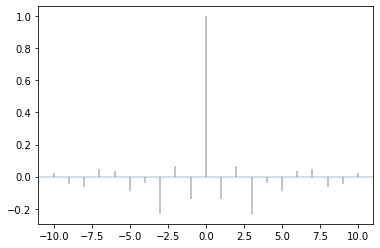

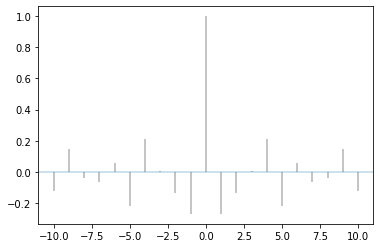

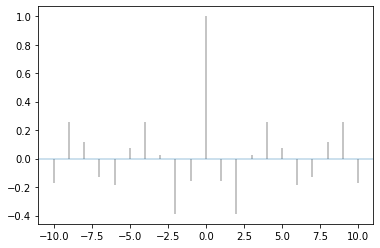

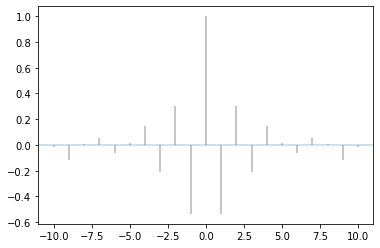

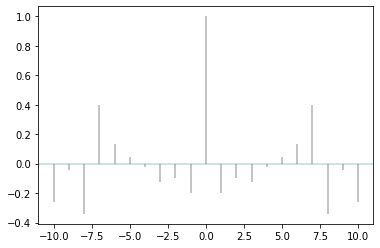

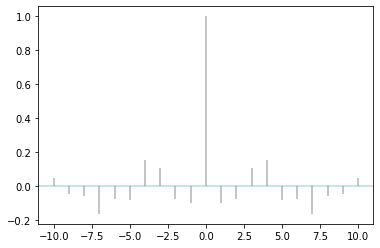

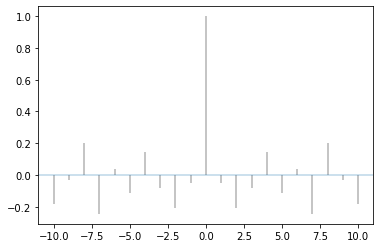

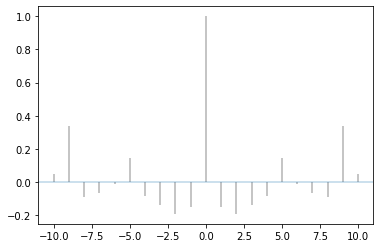

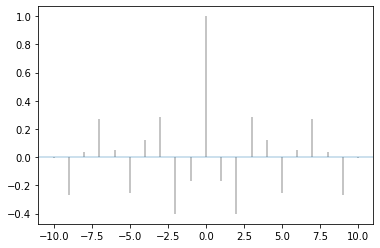

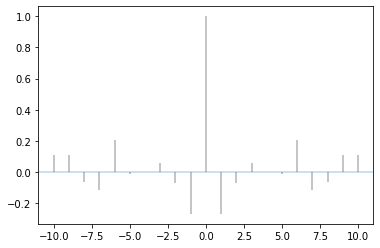

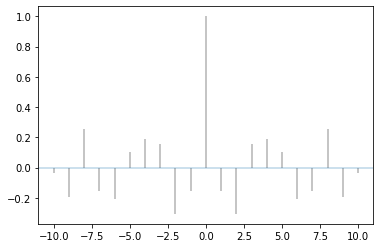

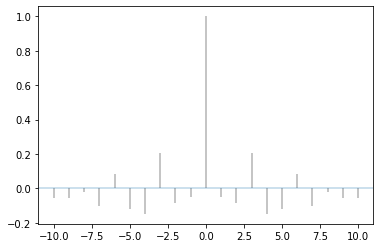

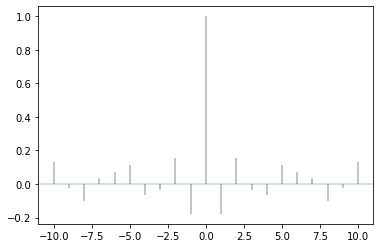

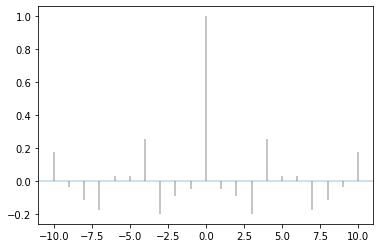

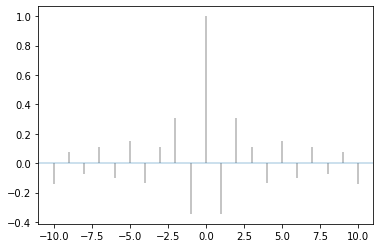

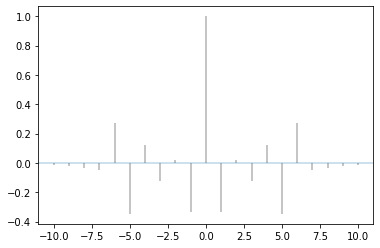

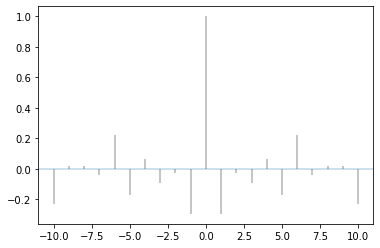

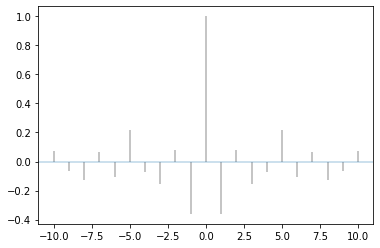

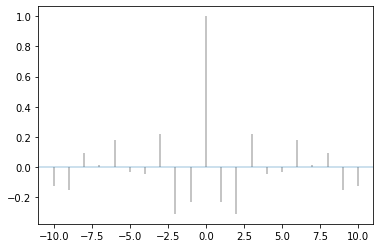

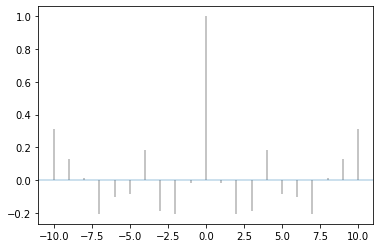

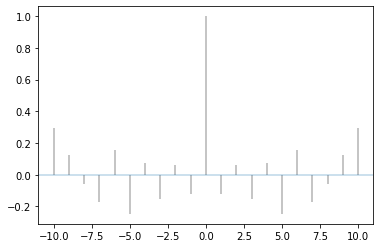

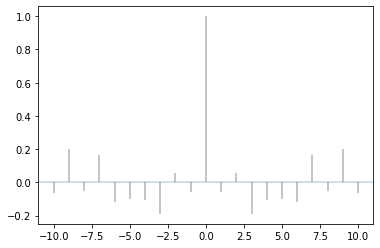

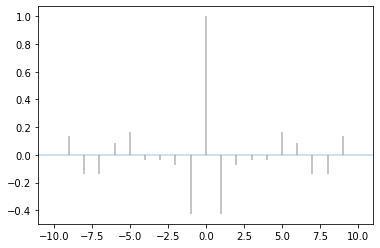

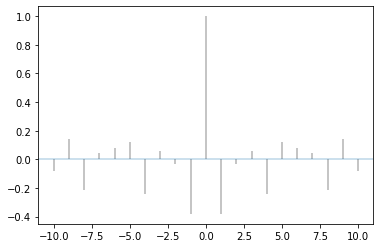

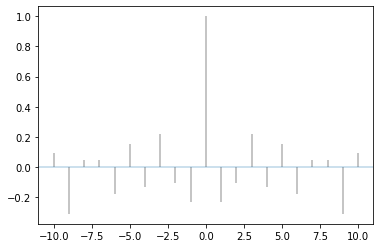

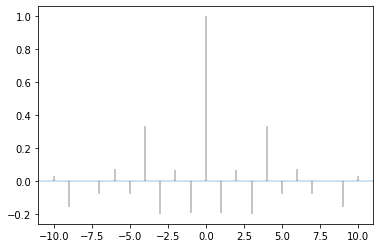

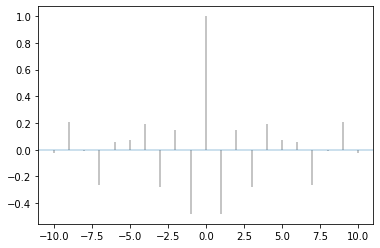

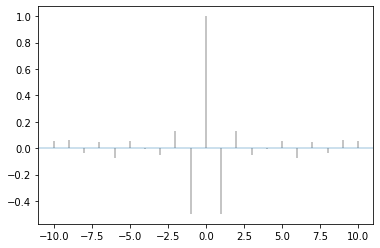

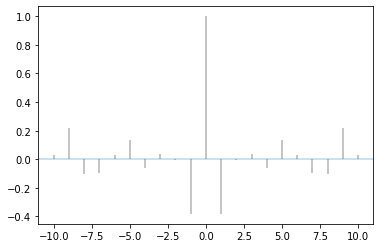

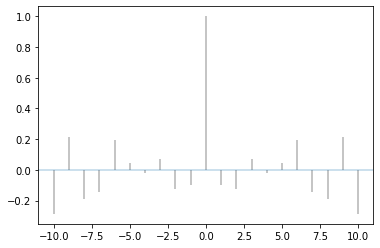

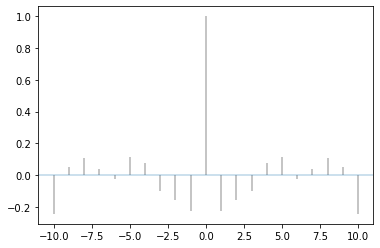

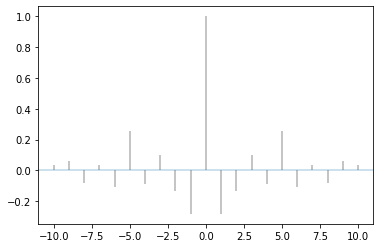

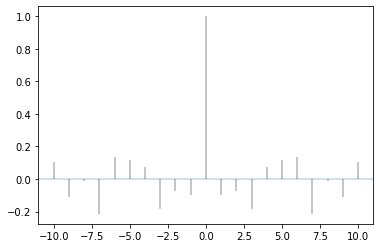

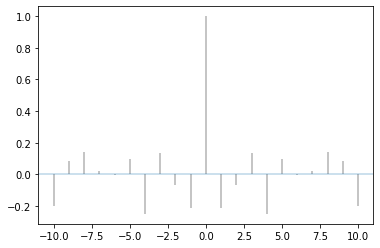

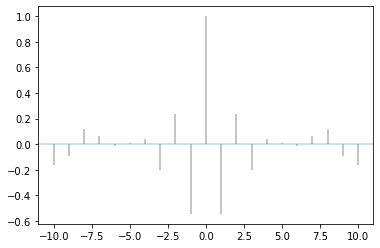

In [131]:
for d in np.unique(all_data.districtId):
    plt.acorr(all_data.loc[all_data.districtId == d,'target'],
              usevlines=True,alpha=.3)
    plt.show()